#Intro

This project builds a fully end‑to‑end pipeline that takes raw, messy movie data and turns it into a time‑aware model that predicts the opening weekend for Avatar: Fire and Ash, then expresses that prediction in real dollars.
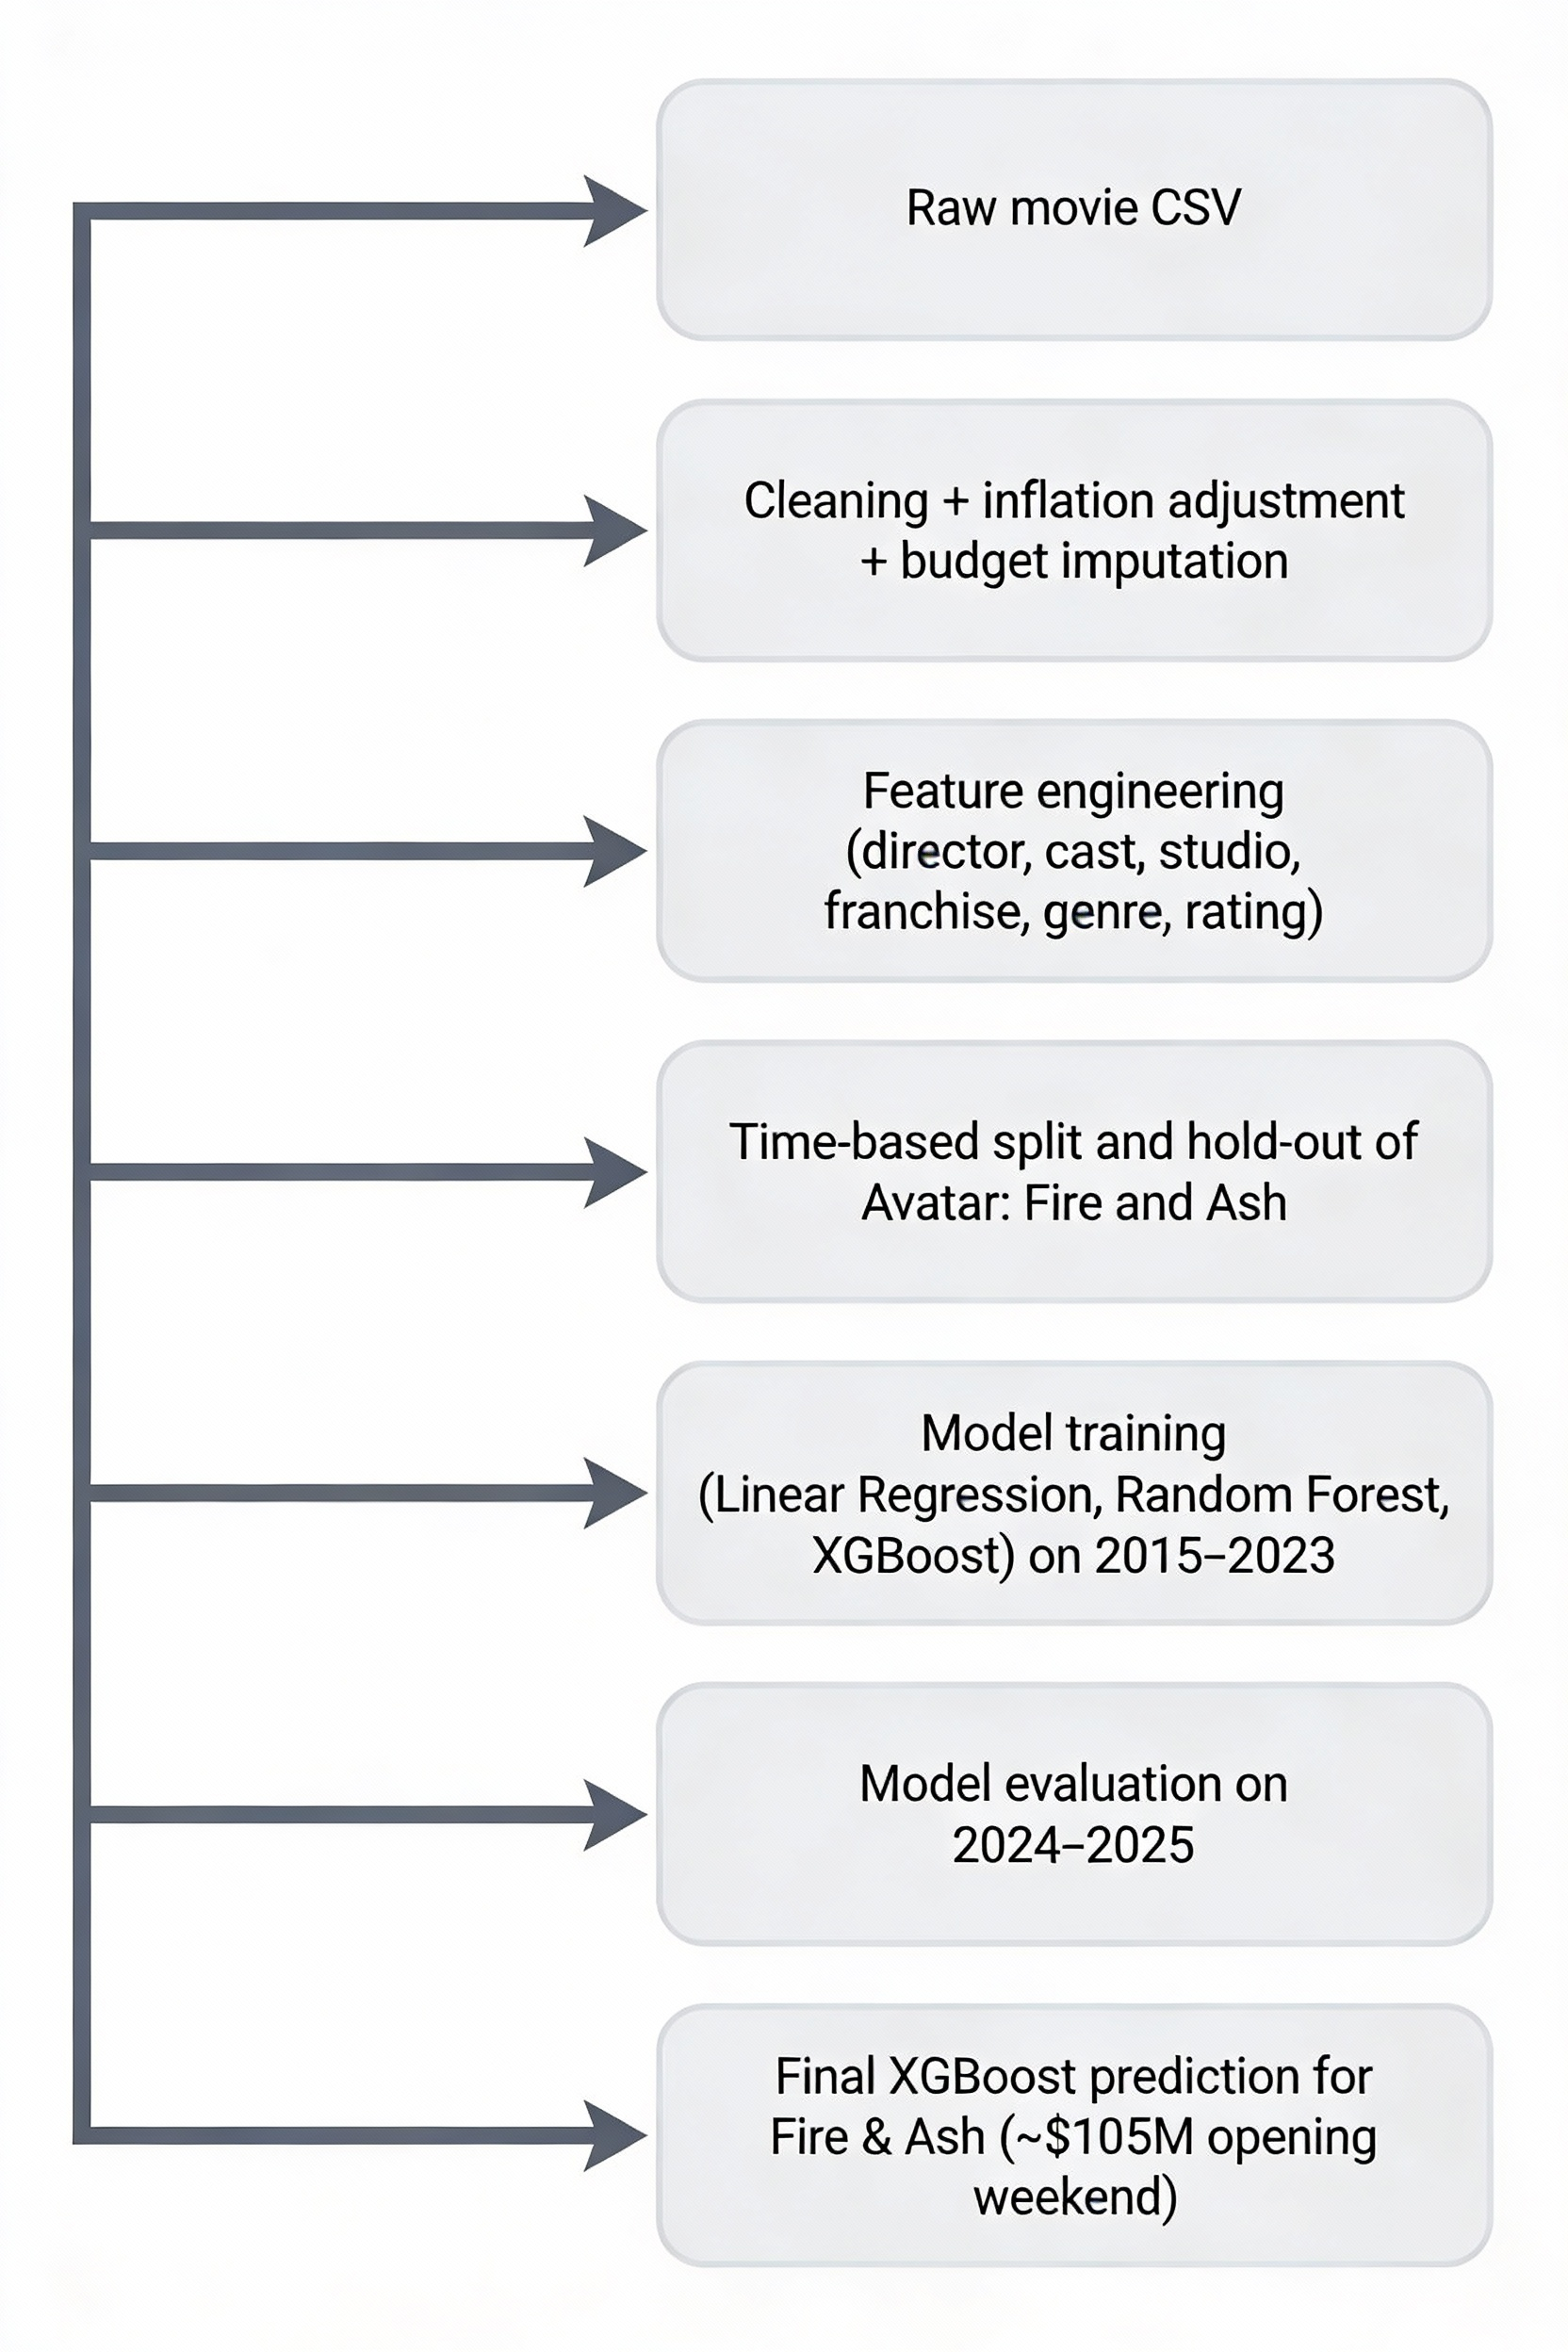
## Raw data and aggressive cleaning

The process starts from a large raw CSV (`madbepar.csv`) containing thousands of films with inconsistent formatting, missing values, and noisy entries. The first major step is an **aggressive cleaning pass**: reading the CSV robustly (skipping malformed lines), standardizing column types, and dropping clearly unusable rows so that the dataset is internally consistent and safe to transform further. Titles, IDs, dates, and monetary fields are normalized, and obvious outliers or corrupted entries are removed to avoid poisoning later stages. At the end of this step, a cleaner working file is saved as `stage5.csv`, which becomes the base for all downstream processing.

## Inflation adjustment and budget imputation

With a stable base table, the next focus is putting all the money numbers on a comparable footing across time. A dedicated stage converts `release_date` into a year, looks up or applies inflation multipliers, and **inflation‑adjusts budgets and grosses** so that a movie from 2010 and a movie from 2023 are expressed in the same “today’s dollars” space. This produces new adjusted columns (e.g., `budget_adj`, `opening_weekend_domestic_adj`) while preserving the originals for reference, and the result is written to `stage6.csv`.

Even after cleaning and inflation adjustment, many movies still have missing or suspiciously low budgets. To handle this, the pipeline runs a **hierarchical budget imputation** step. It first extracts primary studio and primary genre from list‑like columns, then computes median budgets by (studio, genre) combinations. When a specific film’s budget is missing or below a threshold, the pipeline fills it using, in order: the median for that (studio, genre) pair, then the median for the studio alone, then the median for the genre alone, and finally a global median when nothing else is available. This tiered imputation strategy preserves realistic variation while avoiding over‑reliance on a single global guess. After imputation and cleanup of temporary helper columns, the enriched dataset is saved as `stage7.csv`.

## Director, cast, studio, and franchise features

Once core monetary fields are stabilized, the pipeline shifts to **capturing creative and industrial context** via feature engineering.

First, a director‑focused stage parses a directors column (often stored as a stringified list) into Python lists and uses chronological ordering by `release_date` to compute **director power and momentum**. For each director, the pipeline walks through their filmography in order and creates rolling features like the average inflation‑adjusted opening weekend of their last up‑to‑three films, plus measures of recent performance versus older work. This ensures that when the model sees a film, it only uses information from prior releases, mimicking a real‑world forecasting situation and preventing leakage from future titles. The result is written to `stage8.csv`.

Next, a similar stage focuses on lead actors. It identifies the primary cast members (e.g., `lead_actor_1_name`) and constructs **cast power and momentum** features using a rolling window over each actor’s previous films. As with directors, it ensures strict time ordering so that only prior box office performance contributes to the features for a given film. This step analyzes the historical opening weekends of the leads, turning them into numeric signals about star power trends, and outputs `stage9.csv`.

The studio stage then derives **studio power and momentum**. It extracts a primary studio, aggregates inflation‑adjusted openings for that studio’s past releases, and builds rolling statistics such as average opening over the last few releases and possibly longer‑term averages. These metrics encode how strong a studio has been at opening movies recently, which is a powerful predictor for big releases. The resulting enriched dataset is saved as `stage10.csv`.

Finally, the franchise stage constructs **franchise and sequel features**. Using collection or series identifiers, it groups films into franchises and sorts them by release date. For each new entry, it calculates attributes like the previous film’s adjusted opening and possibly cumulative franchise performance to date. This creates features such as `prev_opening_adj` that let the model learn patterns like “third entry in a strong franchise with a huge last opening.” These franchise‑aware features are appended and saved as `stage11.csv`.

## Additional feature construction and time‑aware filtering

Subsequent stages (up through `stage15.csv`) refine and expand the feature space: handling one‑hot or encoded categorical variables, bundling log transforms where appropriate, and ensuring all relevant numeric predictors are in place. The dataset gradually evolves into a **model‑ready table** where each row is a movie and each column is a well‑defined, machine‑friendly feature: budgets (raw and adjusted), cast/director/studio/franchise momentum metrics, genre indicators, calendar features from the release date, and so on.

At this point, the pipeline performs a crucial split around the target film. In `stage16`, it explicitly **isolates Avatar: Fire and Ash**. It filters the full table to find rows whose title matches “Avatar: Fire and Ash,” saves them separately into `fireandash.csv`, and then removes them from the main dataset. This guarantees that no information from Fire & Ash leaks into training or validation, which is essential for a realistic assessment.

With Fire & Ash removed, the pipeline converts `release_date` to a proper datetime and applies a **time cutoff at 2015‑01‑01**. Movies released before 2015 are dropped from the modeling universe; only those from 2015 onward are kept for training and evaluation. The rationale is that the modern theatrical era has different dynamics (e.g., streaming competition, franchise saturation), and using only more recent data should yield a model more relevant to current conditions. The result of this time‑filtered dataset is saved as `stage16.csv`, which becomes the foundation for model training.

## Time‑based train/validation split and model training

With `stage16.csv` in hand, the project moves into modeling. The pipeline first re‑parses `release_date` as datetime and then defines a **time‑based train/validation split** at 2024‑01‑01. Movies released from 2015‑2013 are assigned to the training set, while movies from 2024–2025 are reserved as a hold‑out validation set. This is a deliberate choice to emulate forecasting: the model only sees older movies during training and then is judged on its ability to predict truly later releases.

The target variable is `opening_weekend_domestic_adj`, which is already log‑transformed using a `log1p` style transform in earlier stages. Identifiers and non‑predictive fields—`tmdb_id`, `title`, and `release_date`—along with the target itself are dropped from the feature matrix. The remaining columns constitute the numerical and encoded features that capture financial, creative, and franchise context.

Three models are trained:

- A **linear regression** baseline, which provides a simple, interpretable reference and makes it easy to see whether more complex models add value.  
- A **Random Forest Regressor** with a controlled depth and 200 trees, leveraging nonlinear relationships and feature interactions while remaining relatively robust.  
- An **XGBoost Regressor** with tuned hyperparameters (number of estimators, learning rate, depth, subsample and column sample fractions) to capture complex non‑linear patterns in the data.

Each model is fitted on the training subset and then serialized to disk (`model_lr.pkl`, `model_rf.pkl`, `model_xgb.pkl`) for reuse. At the same time, the list of feature names used for training is saved (`model_features.pkl`) to preserve the exact column ordering needed at prediction time and ensure that any future data is aligned to the same schema before inference.

## Model evaluation on recent years

Once the models are trained, a dedicated evaluation stage reloads `stage16.csv` and extracts the **validation set** defined by movies released from 2024 onwards. It reconstructs the validation feature matrix in the same way as during training—dropping IDs, titles, dates, and the target—to guarantee consistency.

For each available model file, the stage:

- Loads the model.  
- Generates predictions on the validation features in **log space** (since the target is log‑scaled).  
- Computes **RMSE on the log scale** and \(R^2\) to measure fit quality in the transformed space.  
- Applies the inverse transform (`expm1`) to both true and predicted values to recover real dollars, then computes a **mean absolute error in dollars** as an intuitive metric for how far off predictions are on average in monetary terms.

All models’ metrics are collected, sorted by log‑RMSE (lower is better), and printed in a compact table. The pipeline then identifies the best‑performing model—typically the XGBoost regressor—by its combination of low log‑RMSE and strong \(R^2\), along with a reasonably low average dollar error. This step both validates that the feature engineering was useful and selects the champion model for final prediction.

## Fire & Ash prediction and verdict

The final stage is focused solely on **Avatar: Fire and Ash**. It reads `fireandash.csv`, which contains the fully processed row(s) for Fire & Ash after all cleaning, inflation adjustment, imputation, and feature engineering, but with the target left blank. The script reloads the chosen model (the XGBoost regressor) and the saved `model_features` list.

To avoid any mismatch, it drops the same non‑feature columns used during training (`tmdb_id`, `title`, `release_date`, and `opening_weekend_domestic_adj` if present). Then it checks for any missing feature columns relative to `model_features`; any such columns are added and filled with zeros. Finally, it reorders the DataFrame columns to match `model_features` exactly, so the numerical vector fed into the model aligns perfectly with what the model expects.

The model then produces a single prediction on the **log1p scale**:  
`Predicted log(opening_weekend_domestic_adj + 1): 18.4705`.  

The script applies the inverse transform, `np.expm1`, to convert this value back to dollars, yielding:  
`Predicted opening weekend (USD): $105,112,016` (rounded to the nearest dollar).

This is the pipeline’s **final verdict**: under the assumptions baked into the data (inflation‑adjusted grosses, modern era movies from 2015 onward, hierarchical budget imputation, and the detailed director/cast/studio/franchise momentum features), the best‑performing XGBoost model estimates that *Avatar: Fire and Ash* will open to roughly **$105 million** in inflation‑adjusted domestic box office.

From end to end, the 19‑step workflow moves from raw, noisy movie records through systematic cleaning, economic normalization, carefully time‑respecting feature engineering, chronologically proper training and validation, model selection, and finally a single, coherent prediction for the film of interest.

#Section 0 – TMDB movie harvesting

In this part of the notebook I build the very first version of the dataset by talking directly to the TMDB API. The goal is to automatically collect all English‑language movies between a chosen range of years and save their basic information (title, release date, budget, etc.) into a single CSV file that the rest of the project can use.

I put this logic inside a MovieHarvester class. Once I give it my API key, it goes year by year, asks TMDB which films match the filters, and then downloads detailed metadata for each film. To make this faster, it fetches details for many movies at the same time using multiple threads. At the end, it combines everything into a pandas DataFrame with consistent columns and saves it as revenue_predictor/01_tmdb_movies.csv, which becomes the starting point for all later cleaning and modelling steps.

In [ ]:
import os
import time
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

API_KEY = "5d948acabcc94c68c19772693377b2e3"

class MovieHarvester:
    """
    Parallel movie discovery + metadata extraction from TMDB.
    Handles rate limiting, retries, and caching intelligently.
    """
    def __init__(self, api_key, cache_dir='revenue_predictor/cache'):
        self.api_key = api_key
        self.base_url = "https://api.themoviedb.org/3"
        self.cache_dir = cache_dir
        self.session = requests.Session()
        self.session.headers.update({"User-Agent": "Mozilla/5.0 (MoviePipeline)"})
        os.makedirs(cache_dir, exist_ok=True)


    def discover_and_fetch(self, years, limit_per_year=None):
        """
        Core pipeline: discover + fetch details for all movies in years.

        Args:
            years: iterable of years (e.g., range(2010, 2026))
            limit_per_year: max movies to fetch per year (None = fetch all available)

        Returns:
            DataFrame with columns: tmdb_id, title, release_date, budget, revenue,
                                   runtime, genres, original_language, popularity, vote_average,
                                   vote_count, production_companies, directors, cast, imdb_id
        """
        all_movies = []

        print("📊 STAGE 1: TMDB Movie Discovery")
        print(f"   Discovering movies from {min(years)}-{max(years)}...")

        for year in tqdm(years, desc="   Year range", unit="yr"):
            discovered = self._discover_year(year, limit=limit_per_year)
            print(f"   ✓ {year}: {len(discovered)} movies discovered")

            # Fetch full details in parallel
            detailed = self._fetch_details_parallel(discovered, max_workers=5)
            all_movies.extend(detailed)
            time.sleep(0.1)  # Be nice to API

        df = pd.DataFrame(all_movies)

        # Ensure all columns exist in the correct order
        expected_columns = ['tmdb_id', 'title', 'release_date', 'budget', 'revenue', 'runtime',
                          'genres', 'original_language', 'popularity', 'vote_average', 'vote_count',
                          'production_companies', 'directors', 'cast', 'imdb_id']

        for col in expected_columns:
            if col not in df.columns:
                df[col] = None

        df = df[expected_columns]

        print(f"\n✅ Total movies fetched: {len(df)}")
        return df


    def _discover_year(self, year, limit=None):
        """Discover ALL English-language movies for a given year"""
        all_results = []
        page = 1

        while page <= 500:  # TMDB allows up to 500 pages
            url = f"{self.base_url}/discover/movie"
            params = {
                'api_key': self.api_key,
                'primary_release_year': year,
                'with_original_language': 'en',  # English language only
                'sort_by': 'popularity.desc',
                'vote_count.gte': 50,  # Only movies with 50+ votes
                'page': page,
                'include_adult': False
            }

            try:
                resp = self.session.get(url, params=params, timeout=10)
                resp.raise_for_status()
                data = resp.json()
                results = data.get('results', [])

                if not results:  # No more results
                    break

                all_results.extend(results)

                total_pages = data.get('total_pages', 1)
                if page >= total_pages:
                    break

                page += 1
                time.sleep(0.05)
            except Exception as e:
                print(f"   ⚠️  Discovery error (year {year}, page {page}): {e}")
                break

        # Apply limit only if specified
        if limit:
            return all_results[:limit]
        return all_results


    def _fetch_details_parallel(self, movies, max_workers=5):
        """Fetch full details for multiple movies in parallel"""
        details = []

        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = {
                executor.submit(self._fetch_movie_details, m['id']): m
                for m in movies
            }

            for future in tqdm(as_completed(futures), total=len(futures),
                             desc="   Fetching details", leave=False):
                try:
                    movie_data = future.result()
                    if movie_data:
                        details.append(movie_data)
                except Exception as e:
                    print(f"   ⚠️  Detail fetch error: {e}")

        return details


    def _fetch_movie_details(self, movie_id):
        """Fetch complete movie details including credits"""
        url = f"{self.base_url}/movie/{movie_id}"
        params = {
            'api_key': self.api_key,
            'append_to_response': 'credits,external_ids,release_dates'
        }

        try:
            resp = self.session.get(url, params=params, timeout=10)
            resp.raise_for_status()
            data = resp.json()

            # Extract key fields
            return {
                'tmdb_id': data.get('id'),
                'title': data.get('title'),
                'release_date': data.get('release_date'),
                'budget': data.get('budget'),
                'revenue': data.get('revenue'),
                'runtime': data.get('runtime'),
                'genres': [g['name'] for g in data.get('genres', [])],
                'original_language': data.get('original_language'),
                'popularity': data.get('popularity'),
                'vote_average': data.get('vote_average'),
                'vote_count': data.get('vote_count'),
                'production_companies': [
                    c.get('name') for c in data.get('production_companies', [])
                ],
                'directors': [
                    p.get('name') for p in data.get('credits', {}).get('crew', [])
                    if p.get('job') == 'Director'
                ],
                'cast': [
                    p.get('name') for p in data.get('credits', {}).get('cast', [])[:5]  # Top 5
                ],
                'imdb_id': data.get('external_ids', {}).get('imdb_id'),
            }
        except Exception as e:
            return None


# 🚀 RUN THIS
# Define YEARS (required variable for the script to work)
YEARS = range(2010, 2026)  # Adjust as needed

print("\n" + "="*60)
print("SECTION 1: HARVESTER INITIALIZED")
print("="*60)

harvester = MovieHarvester(API_KEY)
movies_df = harvester.discover_and_fetch(YEARS)  # Fetches ALL English movies from each year

print(f"\n📈 Dataset shape: {movies_df.shape}")
print(f"Columns: {list(movies_df.columns)}")
print(f"\nFirst 3 movies:\n{movies_df[['title', 'release_date', 'budget', 'revenue']].head(3)}")

# Save intermediate result
os.makedirs('revenue_predictor', exist_ok=True)
movies_df.to_csv('revenue_predictor/01_tmdb_movies.csv', index=False)
print("\n✅ Saved to: revenue_predictor/01_tmdb_movies.csv")



SECTION 1: HARVESTER INITIALIZED
📊 STAGE 1: TMDB Movie Discovery
   Discovering movies from 2010-2025...


   Year range:   0%|          | 0/16 [00:00<?, ?yr/s]

   ✓ 2010: 531 movies discovered



   Year range:   6%|▋         | 1/16 [00:18<04:34, 18.29s/yr]

   ✓ 2011: 595 movies discovered



   Year range:  12%|█▎        | 2/16 [00:38<04:35, 19.68s/yr]

   ✓ 2012: 595 movies discovered



   Year range:  19%|█▉        | 3/16 [00:59<04:23, 20.27s/yr]

   ✓ 2013: 666 movies discovered



   Year range:  25%|██▌       | 4/16 [01:23<04:17, 21.42s/yr]

   ✓ 2014: 744 movies discovered



   Year range:  31%|███▏      | 5/16 [01:50<04:18, 23.54s/yr]

   ✓ 2015: 777 movies discovered



   Year range:  38%|███▊      | 6/16 [02:18<04:10, 25.01s/yr]

   ✓ 2016: 769 movies discovered



   Year range:  44%|████▍     | 7/16 [02:46<03:54, 26.01s/yr]

   ✓ 2017: 826 movies discovered



   Year range:  50%|█████     | 8/16 [03:16<03:39, 27.46s/yr]

   ✓ 2018: 807 movies discovered



   Year range:  56%|█████▋    | 9/16 [03:46<03:16, 28.11s/yr]

   ✓ 2019: 751 movies discovered



   Year range:  62%|██████▎   | 10/16 [04:13<02:46, 27.77s/yr]

   ✓ 2020: 645 movies discovered



   Year range:  69%|██████▉   | 11/16 [04:36<02:11, 26.32s/yr]

   ✓ 2021: 615 movies discovered



   Year range:  75%|███████▌  | 12/16 [04:58<01:39, 24.97s/yr]

   ✓ 2022: 606 movies discovered



   Year range:  81%|████████▏ | 13/16 [05:19<01:11, 23.82s/yr]

   ✓ 2023: 535 movies discovered



   Year range:  88%|████████▊ | 14/16 [05:38<00:44, 22.40s/yr]

   ✓ 2024: 457 movies discovered



   Year range:  94%|█████████▍| 15/16 [05:58<00:21, 21.74s/yr]

   ✓ 2025: 291 movies discovered



   Year range: 100%|██████████| 16/16 [06:07<00:00, 22.99s/yr]



✅ Total movies fetched: 10210

📈 Dataset shape: (10210, 15)
Columns: ['tmdb_id', 'title', 'release_date', 'budget', 'revenue', 'runtime', 'genres', 'original_language', 'popularity', 'vote_average', 'vote_count', 'production_companies', 'directors', 'cast', 'imdb_id']

First 3 movies:
        title release_date     budget    revenue
0   Inception   2010-07-15  160000000  839030630
1     Tangled   2010-11-24  260000000  592461732
2  Iron Man 2   2010-04-28  200000000  623933331

✅ Saved to: revenue_predictor/01_tmdb_movies.csv


#Section 1 – Adding extra information from TMDB

In this section I take the raw movie list from the previous step and add a bit more useful information to it using the TMDB API again. The main idea is to “enrich” each movie with its MPAA rating (e.g. PG‑13, R) and its collection id (franchise/series id), because these are not included in the first bulk download but are important for later analysis.

To keep things organised, I use a MovieEnricher class. It loads the existing CSV of movies, reads all their TMDB ids, and then sends extra API requests in parallel to look up the rating and collection for every film. Once these values are fetched, they are matched back to the original movies and stored as two new columns, mpaa_rating and collection_id. Finally, the enriched dataset is saved as revenue_predictor/02_tmdb_movies_enriched.csv, which is the version used in the next stages of the pipeline.

In [ ]:
import os
import time
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

API_KEY = "5d948acabcc94c68c19772693377b2e3"

class MovieEnricher:
    """
    Enrich existing movie dataset with additional metadata from TMDB.
    Adds MPAA rating and collection_id to already scraped movies.
    """
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://api.themoviedb.org/3"
        self.session = requests.Session()
        self.session.headers.update({"User-Agent": "Mozilla/5.0 (MoviePipeline)"})


    def enrich_movies(self, csv_path, max_workers=5):
        """
        Load scraped movies and enrich with MPAA rating and collection_id.

        Args:
            csv_path: path to the CSV file with scraped movies
            max_workers: number of parallel workers for API requests

        Returns:
            DataFrame with added columns: mpaa_rating, collection_id
        """
        # Load existing movies
        print("📂 Loading existing movie dataset...")
        df = pd.read_csv(csv_path)
        print(f"   ✓ Loaded {len(df)} movies from CSV")

        # Extract TMDB IDs
        tmdb_ids = df['tmdb_id'].tolist()

        print("\n📊 STAGE 1: Enriching movies with MPAA rating and collection_id")
        print(f"   Processing {len(tmdb_ids)} movies...")

        # Fetch additional details in parallel
        enriched_data = self._fetch_enrichment_parallel(tmdb_ids, max_workers=max_workers)

        # Create a dictionary for easy lookup
        enrichment_dict = {item['tmdb_id']: item for item in enriched_data}

        # Add new columns to dataframe
        df['mpaa_rating'] = df['tmdb_id'].map(lambda x: enrichment_dict.get(x, {}).get('mpaa_rating'))
        df['collection_id'] = df['tmdb_id'].map(lambda x: enrichment_dict.get(x, {}).get('collection_id'))

        print(f"\n✅ Total movies enriched: {len(df)}")
        return df


    def _fetch_enrichment_parallel(self, tmdb_ids, max_workers=5):
        """Fetch MPAA rating and collection_id for multiple movies in parallel"""
        enriched = []

        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = {
                executor.submit(self._fetch_movie_enrichment, movie_id): movie_id
                for movie_id in tmdb_ids
            }

            for future in tqdm(as_completed(futures), total=len(futures),
                             desc="   Fetching enrichment data", leave=False):
                try:
                    enrichment_data = future.result()
                    if enrichment_data:
                        enriched.append(enrichment_data)
                except Exception as e:
                    print(f"   ⚠️  Enrichment fetch error: {e}")

        return enriched


    def _fetch_movie_enrichment(self, movie_id):
        """Fetch MPAA rating and collection_id for a single movie"""
        url = f"{self.base_url}/movie/{movie_id}"
        params = {
            'api_key': self.api_key,
            'append_to_response': 'release_dates'
        }

        try:
            resp = self.session.get(url, params=params, timeout=10)
            resp.raise_for_status()
            data = resp.json()

            # Extract MPAA rating from release_dates
            mpaa_rating = None
            release_dates = data.get('release_dates', {}).get('results', [])
            for country_data in release_dates:
                if country_data.get('iso_3166_1') == 'US':  # US releases have MPAA ratings
                    releases = country_data.get('release_dates', [])
                    if releases:
                        mpaa_rating = releases[0].get('certification')
                    break

            # Extract collection_id
            collection_id = None
            belongs_to_collection = data.get('belongs_to_collection')
            if belongs_to_collection:
                collection_id = belongs_to_collection.get('id')

            return {
                'tmdb_id': data.get('id'),
                'mpaa_rating': mpaa_rating,
                'collection_id': collection_id,
            }
        except Exception as e:
            return None


# 🚀 RUN THIS
print("\n" + "="*60)
print("MOVIE ENRICHMENT PIPELINE (FULL DATASET)")
print("="*60)

enricher = MovieEnricher(API_KEY)
enriched_df = enricher.enrich_movies('/content/revenue_predictor/01_tmdb_movies.csv', max_workers=5)

print(f"\n📈 Enriched dataset shape: {enriched_df.shape}")
print(f"Columns: {list(enriched_df.columns)}")
print(f"\nFirst 3 movies:\n{enriched_df[['title', 'mpaa_rating', 'collection_id']].head(3)}")

# Save enriched result
os.makedirs('revenue_predictor', exist_ok=True)
enriched_df.to_csv('revenue_predictor/02_tmdb_movies_enriched.csv', index=False)
print("\n✅ Saved to: revenue_predictor/02_tmdb_movies_enriched.csv")



MOVIE ENRICHMENT PIPELINE (FULL DATASET)
📂 Loading existing movie dataset...
   ✓ Loaded 10210 movies from CSV

📊 STAGE 1: Enriching movies with MPAA rating and collection_id
   Processing 10210 movies...



✅ Total movies enriched: 10210

📈 Enriched dataset shape: (10210, 17)
Columns: ['tmdb_id', 'title', 'release_date', 'budget', 'revenue', 'runtime', 'genres', 'original_language', 'popularity', 'vote_average', 'vote_count', 'production_companies', 'directors', 'cast', 'imdb_id', 'mpaa_rating', 'collection_id']

First 3 movies:
        title mpaa_rating  collection_id
0   Inception       PG-13            NaN
1     Tangled          PG      1268789.0
2  Iron Man 2       PG-13       131292.0

✅ Saved to: revenue_predictor/02_tmdb_movies_enriched.csv


#Section 2 – Adding lead actor information

Here I extend the movie dataset by attaching information about the two main actors in each film. The idea is that star power might help explain box office performance later, so I want to know who the leads are and which characters they play.

To do this, I use a LeadActorScraper class. It reads the existing CSV of movies, takes the TMDB id for each title, and then calls the TMDB API again (this time asking for the full credits). For every movie it pulls out the first two cast members, and records their names, TMDB ids, and character names. These values are added as new columns (for lead actor 1 and lead actor 2) and the updated dataset is saved as 04_tmdb_movies_with_lead_actors.csv, which is the enriched input used by the later stages of the project.

In [ ]:
import os
import time
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

API_KEY = "5d948acabcc94c68c19772693377b2e3"

class LeadActorScraper:
    """
    Extract lead actor data from TMDB for movies in dataset.
    Gets lead actor 1 and lead actor 2 details.
    """
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://api.themoviedb.org/3"
        self.session = requests.Session()
        self.session.headers.update({"User-Agent": "Mozilla/5.0 (MoviePipeline)"})

    def enrich_with_lead_actors(self, csv_path, max_workers=5):
        """
        Load movies and add lead actor 1 and lead actor 2 data from TMDB.

        Args:
            csv_path: path to the CSV file with movies
            max_workers: number of parallel workers for API requests

        Returns:
            DataFrame with added columns:
            - lead_actor_1_name, lead_actor_1_id, lead_actor_1_character
            - lead_actor_2_name, lead_actor_2_id, lead_actor_2_character
        """
        # Load existing movies
        print("📂 Loading movie dataset...")
        df = pd.read_csv(csv_path)
        print(f"   ✓ Loaded {len(df)} movies from CSV")

        # Extract TMDB IDs
        tmdb_ids = df['tmdb_id'].tolist()

        print("\n📊 STAGE 1: Fetching lead actor data from TMDB")
        print(f"   Processing {len(tmdb_ids)} movies...")

        # Fetch lead actor data in parallel
        actor_data = self._fetch_lead_actors_parallel(tmdb_ids, max_workers=max_workers)

        # Create a dictionary for easy lookup
        actor_dict = {item['tmdb_id']: item for item in actor_data}

        # Add new columns to dataframe
        df['lead_actor_1_name'] = df['tmdb_id'].map(lambda x: actor_dict.get(x, {}).get('lead_actor_1_name'))
        df['lead_actor_1_id'] = df['tmdb_id'].map(lambda x: actor_dict.get(x, {}).get('lead_actor_1_id'))
        df['lead_actor_1_character'] = df['tmdb_id'].map(lambda x: actor_dict.get(x, {}).get('lead_actor_1_character'))

        df['lead_actor_2_name'] = df['tmdb_id'].map(lambda x: actor_dict.get(x, {}).get('lead_actor_2_name'))
        df['lead_actor_2_id'] = df['tmdb_id'].map(lambda x: actor_dict.get(x, {}).get('lead_actor_2_id'))
        df['lead_actor_2_character'] = df['tmdb_id'].map(lambda x: actor_dict.get(x, {}).get('lead_actor_2_character'))

        print(f"\n✅ Total movies processed: {len(df)}")
        return df

    def _fetch_lead_actors_parallel(self, tmdb_ids, max_workers=5):
        """Fetch lead actor data for multiple movies in parallel"""
        actor_data = []

        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = {
                executor.submit(self._fetch_lead_actors, movie_id): movie_id
                for movie_id in tmdb_ids
            }

            for future in tqdm(as_completed(futures), total=len(futures),
                             desc="   Fetching lead actors", leave=False):
                try:
                    data = future.result()
                    if data:
                        actor_data.append(data)
                except Exception as e:
                    print(f"   ⚠️  Lead actor fetch error: {e}")

        return actor_data

    def _fetch_lead_actors(self, movie_id):
        """Fetch lead actor 1 and lead actor 2 for a single movie"""
        url = f"{self.base_url}/movie/{movie_id}"
        params = {
            'api_key': self.api_key,
            'append_to_response': 'credits'
        }

        try:
            resp = self.session.get(url, params=params, timeout=10)
            resp.raise_for_status()
            data = resp.json()

            # Extract cast
            cast = data.get('credits', {}).get('cast', [])

            # Get lead actor 1 (first in cast)
            lead_actor_1_name = None
            lead_actor_1_id = None
            lead_actor_1_character = None

            if len(cast) > 0:
                lead_actor_1_name = cast[0].get('name')
                lead_actor_1_id = cast[0].get('id')
                lead_actor_1_character = cast[0].get('character')

            # Get lead actor 2 (second in cast)
            lead_actor_2_name = None
            lead_actor_2_id = None
            lead_actor_2_character = None

            if len(cast) > 1:
                lead_actor_2_name = cast[1].get('name')
                lead_actor_2_id = cast[1].get('id')
                lead_actor_2_character = cast[1].get('character')

            return {
                'tmdb_id': data.get('id'),
                'lead_actor_1_name': lead_actor_1_name,
                'lead_actor_1_id': lead_actor_1_id,
                'lead_actor_1_character': lead_actor_1_character,
                'lead_actor_2_name': lead_actor_2_name,
                'lead_actor_2_id': lead_actor_2_id,
                'lead_actor_2_character': lead_actor_2_character,
            }
        except Exception as e:
            return None


# 🚀 RUN THIS
print("\n" + "="*60)
print("LEAD ACTOR DATA PIPELINE (FULL DATASET)")
print("="*60)

scraper = LeadActorScraper(API_KEY)
actor_df = scraper.enrich_with_lead_actors('/content/revenue_predictor/02_tmdb_movies_enriched.csv', max_workers=5)

print(f"\n📈 Final dataset shape: {actor_df.shape}")
print(f"Columns: {list(actor_df.columns)}")
print(f"\nFirst 5 movies with lead actors:\n{actor_df[['title', 'lead_actor_1_name', 'lead_actor_1_character', 'lead_actor_2_name', 'lead_actor_2_character']].head(5)}")

# Save final result
os.makedirs('revenue_predictor', exist_ok=True)
actor_df.to_csv('revenue_predictor/04_tmdb_movies_with_lead_actors.csv', index=False)
print("\n✅ Saved to: revenue_predictor/04_tmdb_movies_with_lead_actors.csv")



LEAD ACTOR DATA PIPELINE (FULL DATASET)
📂 Loading movie dataset...
   ✓ Loaded 10210 movies from CSV

📊 STAGE 1: Fetching lead actor data from TMDB
   Processing 10210 movies...



✅ Total movies processed: 10210

📈 Final dataset shape: (10210, 23)
Columns: ['tmdb_id', 'title', 'release_date', 'budget', 'revenue', 'runtime', 'genres', 'original_language', 'popularity', 'vote_average', 'vote_count', 'production_companies', 'directors', 'cast', 'imdb_id', 'mpaa_rating', 'collection_id', 'lead_actor_1_name', 'lead_actor_1_id', 'lead_actor_1_character', 'lead_actor_2_name', 'lead_actor_2_id', 'lead_actor_2_character']

First 5 movies with lead actors:
                                               title  lead_actor_1_name  \
0                                          Inception  Leonardo DiCaprio   
1                                            Tangled        Mandy Moore   
2                                         Iron Man 2  Robert Downey Jr.   
3       Harry Potter and the Deathly Hallows: Part 1   Daniel Radcliffe   
4  Percy Jackson & the Olympians: The Lightning T...       Logan Lerman   

  lead_actor_1_character     lead_actor_2_name lead_actor_2_character  
0

#Section 3 – Scraping opening weekend box office

In this section I collect the **opening‑weekend domestic box office** for each film by scraping the Box Office Mojo website. TMDB does not provide this number directly, so I have to visit the Box Office Mojo page for each IMDb id and look for the “Opening” line on the page.

The function `get_opening_weekend_mojo` handles the actual web scraping for a single movie. It sends an HTTP request to the movie’s Box Office Mojo page, waits for the HTML to load, and then uses a regular expression to search the page text for the opening weekend dollar amount. To avoid the site blocking me, it includes retry logic, exponential back‑off for 503 “Service Unavailable” errors, and returns both the value and a status message so I can see what went wrong when data is missing.

The main driver is `fetch_opening_weekend_data_parallel`. It reads the movie list from a CSV, then uses **multiple threads** to scrape many Box Office Mojo pages at the same time, but with a **small delay and only two workers** to be respectful to the website. As each result comes back, it safely writes the opening weekend number and a status flag into the DataFrame. At the end it saves the updated dataset with two new columns, `opening_weekend_domestic` and `box_office_status`, and prints some summary statistics (success rate, distribution of statuses, and basic box office summary). This enriched file becomes the version used later when adjusting for inflation and building the prediction model.

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
from tqdm import tqdm
import re
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed
from threading import Lock
import random

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

data_lock = Lock()

def get_opening_weekend_mojo(imdb_id, timeout=15, max_retries=3):
    """Scrape opening weekend data from Box Office Mojo with retry logic"""
    if pd.isna(imdb_id) or imdb_id == '':
        return None, "Missing IMDb ID"

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36',
        'Accept-Language': 'en-US,en;q=0.9',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
    }

    for attempt in range(max_retries):
        try:
            url = f"https://www.boxofficemojo.com/title/{imdb_id}/"
            response = requests.get(url, headers=headers, timeout=timeout)

            # 503 = Service Unavailable, backoff and retry
            if response.status_code == 503:
                backoff_time = 5 * (2 ** attempt) + random.uniform(0, 2)  # Exponential backoff
                time.sleep(backoff_time)
                continue

            response.raise_for_status()

            soup = BeautifulSoup(response.content, 'html.parser')
            text = soup.get_text()

            # Look for "Opening" followed by $ amount
            pattern = r'Opening[^$]*?\$\s*([\d,]+)'
            match = re.search(pattern, text, re.IGNORECASE)

            if match:
                amount_str = match.group(1).replace(',', '')
                opening_weekend = float(amount_str)
                return opening_weekend, "success"

            return None, "Opening weekend data not found"

        except requests.exceptions.HTTPError as e:
            if e.response.status_code == 404:
                return None, "Movie not found (404)"
            elif e.response.status_code == 503:
                continue  # Retry on 503
            return None, f"HTTP {e.response.status_code}"
        except requests.exceptions.Timeout:
            if attempt < max_retries - 1:
                time.sleep(2 * (attempt + 1))
                continue
            return None, "Request timeout"
        except requests.exceptions.ConnectionError:
            if attempt < max_retries - 1:
                time.sleep(2 * (attempt + 1))
                continue
            return None, "Connection error"
        except Exception as e:
            return None, f"Error: {type(e).__name__}"

    return None, "Max retries exceeded"


def process_movie(row, delay=0.5):
    """Process single movie with longer delay"""
    imdb_id = row['imdb_id']
    title = row.get('title', 'Unknown')
    idx = row.name

    # Increase delay between requests to avoid 503s
    time.sleep(delay)

    opening_weekend, status = get_opening_weekend_mojo(imdb_id, timeout=15, max_retries=3)

    return idx, opening_weekend, status


def fetch_opening_weekend_data_parallel(csv_file, output_file='madbepar.csv',
                                        num_workers=2, delay=0.8):
    """Fetch opening weekend data using parallel threads (FEWER workers, LONGER delays)"""

    logger.info(f"Loading dataset from {csv_file}")
    df = pd.read_csv(csv_file)

    logger.info(f"Processing {len(df)} movies with {num_workers} parallel workers")
    logger.info(f"Request delay: {delay}s per request")
    logger.info(f"Estimated time: ~{len(df) * delay / num_workers / 60:.1f} minutes")

    df['opening_weekend_domestic'] = None
    df['box_office_status'] = None

    successful_count = 0
    failed_count = 0

    # Reduce num_workers from 4 to 2, increase delay from 0.3 to 0.8
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(process_movie, row, delay): idx
                  for idx, row in df.iterrows()}

        with tqdm(total=len(df), desc="Scraping Box Office Mojo") as pbar:
            for future in as_completed(futures):
                try:
                    idx, opening_weekend, status = future.result()

                    with data_lock:
                        df.at[idx, 'opening_weekend_domestic'] = opening_weekend
                        df.at[idx, 'box_office_status'] = status

                        if opening_weekend is not None:
                            successful_count += 1
                        else:
                            failed_count += 1

                    pbar.update(1)

                except Exception as e:
                    logger.error(f"Error processing movie: {e}")
                    pbar.update(1)

    df.to_csv(output_file, index=False)

    logger.info(f"\n{'='*70}")
    logger.info(f"✓ SCRAPING COMPLETE!")
    logger.info(f"Successfully retrieved: {successful_count} movies")
    logger.info(f"Failed to retrieve: {failed_count} movies")
    logger.info(f"Success rate: {successful_count/len(df)*100:.1f}%")
    logger.info(f"Results saved to: {output_file}")
    logger.info(f"{'='*70}")

    # Show status distribution
    status_dist = df['box_office_status'].value_counts()
    print("\n" + "="*70)
    print("STATUS DISTRIBUTION")
    print("="*70)
    print(status_dist)
    print("="*70)

    # Show sample successful results
    successful_df = df[df['opening_weekend_domestic'].notna()]
    if len(successful_df) > 0:
        print("\n" + "="*70)
        print("SAMPLE SUCCESSFUL RESULTS (First 10)")
        print("="*70)
        print(successful_df[['title', 'imdb_id', 'opening_weekend_domestic']].head(10).to_string(index=False))
        print("="*70)

        print("\n" + "="*70)
        print("BOX OFFICE STATISTICS")
        print("="*70)
        print(f"Average opening weekend: ${successful_df['opening_weekend_domestic'].mean():,.0f}")
        print(f"Median opening weekend: ${successful_df['opening_weekend_domestic'].median():,.0f}")
        print(f"Minimum opening weekend: ${successful_df['opening_weekend_domestic'].min():,.0f}")
        print(f"Maximum opening weekend: ${successful_df['opening_weekend_domestic'].max():,.0f}")
        print(f"Total opening weekend across all movies: ${successful_df['opening_weekend_domestic'].sum():,.0f}")
        print("="*70)

    return df


if __name__ == "__main__":
    # FIX: Changed from num_workers=4, delay=0.3 → num_workers=2, delay=0.8
    # This avoids 503 errors by hitting the server less aggressively
    df = fetch_opening_weekend_data_parallel('04_tmdb_movies_with_lead_actors.csv',
                                             num_workers=2,
                                             delay=0.8)


Scraping Box Office Mojo: 100%|██████████| 10210/10210 [1:35:25<00:00,  1.78it/s]



STATUS DISTRIBUTION
box_office_status
success                           5696
Opening weekend data not found    4495
Missing IMDb ID                     19
Name: count, dtype: int64

SAMPLE SUCCESSFUL RESULTS (First 10)
                                             title   imdb_id opening_weekend_domestic
                                         Inception tt1375666               62785337.0
                                           Tangled tt0398286               48767052.0
                                        Iron Man 2 tt1228705              128122480.0
      Harry Potter and the Deathly Hallows: Part 1 tt0926084              125017372.0
Percy Jackson & the Olympians: The Lightning Thief tt0814255               31236067.0
                          How to Train Your Dragon tt0892769               43732319.0
                               Shrek Forever After tt0892791               70838207.0
                                       Toy Story 3 tt0435761              110307189.0
      

#Section 4 – Manually adding Avatar 3 to the dataset

Here I manually insert a new row into the **`madbepar.csv`** file for *Avatar: Fire and Ash*, since this movie does not yet appear in the historical data pulled from TMDB and Box Office Mojo. The goal is to give the model a complete set of input features for Avatar 3, using reasonable assumptions from publicly available information (budget, runtime, cast, etc.), so that it can generate a prediction for its opening weekend.

The code first loads the existing `madbepar.csv` into a pandas DataFrame and then builds a dictionary called `new_row` that matches the exact column structure of the dataset. This dictionary fills in values such as the TMDB id, title, release date, budget, runtime, genre list, main production companies, director, top cast, IMDb id, MPAA rating, and franchise `collection_id`. It also sets `opening_weekend_domestic` to 0, because the film has not yet been released and this is the value the model is supposed to predict later. Finally, the new row is appended to the DataFrame, written back to `madbepar.csv`, and the script prints a short confirmation showing that the Avatar 3 entry has been successfully added.

In [ ]:
import pandas as pd
import numpy as np

# Load existing madbepar
df = pd.read_csv("madbepar.csv")

# Create new Avatar 3 row matching your CSV structure
new_row = {
    "tmdb_id": 83533,  # TMDB numeric ID
    "title": "Avatar: Fire and Ash",
    "release_date": "19/12/25",  # matching date format (day/month/year)
    "budget": 400000000,
    "runtime": 197,
    "genres": "['Action', 'Adventure', 'Science Fiction']",
    "popularity": 0,
    "vote_average": 0,
    "vote_count": 0,
    "production_companies": "['20th Century Studios', 'Lightstorm Entertainment']",
    "directors": "['James Cameron']",
    "cast": "['Sam Worthington', 'Zoe Saldaña', 'Sigourney Weaver', 'Stephen Lang', 'Kate Winslet']",
    "imdb_id": "tt1757678",
    "mpaa_rating": "PG-13",
    "collection_id": 87096.0,
    "lead_actor_1_name": "Sam Worthington",
    "lead_actor_1_id": 65731,
    "lead_actor_1_character": "Jake Sully",
    "lead_actor_2_name": "Zoe Saldaña",
    "lead_actor_2_id": 8691,
    "lead_actor_2_character": "Neytiri",
    "opening_weekend_domestic": 0
}

# Append and save
df_updated = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
df_updated.to_csv("madbepar.csv", index=False)

print("✅ Avatar: Fire and Ash added to madbepar.csv")
print(f"Total rows: {len(df_updated)}")
print("\nNew entry:")
print(df_updated[df_updated["title"] == "Avatar: Fire and Ash"][
    ["title", "release_date", "budget", "imdb_id", "collection_id"]
])


✅ Avatar: Fire and Ash added to madbepar.csv
Total rows: 5645

New entry:
                     title release_date     budget    imdb_id  collection_id
5644  Avatar: Fire and Ash     19/12/25  400000000  tt1757678      87,096.00


#Stage 5 – Cleaning the raw movie dataset

This stage takes the combined movie file madbepar.csv and cleans it so that later steps do not break on messy or inconsistent rows. The overall goal is to make sure each movie has a valid id, a valid release date, and sensible numeric values before any feature engineering is applied.

The function first reads the CSV while skipping any badly formatted lines. It then removes “garbage” rows by forcing tmdb_id to be numeric and dropping entries where this conversion fails. To avoid duplicates, it keeps only the last record for each tmdb_id. Next, it converts the release_date column into a proper date type and drops any rows where the date cannot be parsed. Finally, it cleans the main numeric fields (budget, revenue, opening_weekend_domestic, and runtime) by coercing non‑numeric values to numbers and replacing missing values with 0. The cleaned dataset is saved as stage5.csv, and a short summary and preview are printed to confirm how many rows were kept.

In [ ]:
input_file = "madbepar.csv"
output_file = "stage5.csv"


def clean_data_aggressive():
    print(f"cleaning data from {input_file}...")

    if not os.path.exists(input_file):
        print("input file not found. please run task 05 first.")
        return

    # 1. read csv, skip badly formed rows
    try:
        data = pd.read_csv(input_file, on_bad_lines="skip", low_memory=False)
    except Exception as err:
        print(f"could not read file: {err}")
        return

    initial_rows = len(data)
    print(f"loaded {initial_rows} rows.")

    # 2. remove stray header/garbage rows using tmdb_id
    if "tmdb_id" not in data.columns:
        print("column 'tmdb_id' is missing. cannot continue.")
        return

    data["tmdb_id"] = pd.to_numeric(data["tmdb_id"], errors="coerce")
    rows_before_filter = len(data)
    data = data.dropna(subset=["tmdb_id"])
    print(f"removed {rows_before_filter - len(data)} invalid rows.")

    # 3. drop duplicate movies, keep the latest
    data = data.drop_duplicates(subset=["tmdb_id"], keep="last")

    # 4. remove rows without a valid release date
    if "release_date" not in data.columns:
        print("column 'release_date' is missing. cannot enforce date filter.")
        return

    data["release_date"] = pd.to_datetime(data["release_date"], errors="coerce")
    missing_dates = data["release_date"].isna().sum()
    data = data.dropna(subset=["release_date"])
    print(f"removed {missing_dates} rows with missing release dates.")

    # 5. clean numeric columns (set bad values to 0)
    numeric_cols = ["budget", "revenue", "opening_weekend_domestic", "runtime"]
    for col in numeric_cols:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col], errors="coerce").fillna(0)

    # 6. save cleaned data
    data.to_csv(output_file, index=False)

    print("-" * 40)
    print("cleaning complete.")
    print(f"original rows: {initial_rows}")
    print(f"clean rows:    {len(data)}")
    print(f"saved as:      {output_file}")
    print("-" * 40)

    # quick preview
    preview_cols = [col for col in ["tmdb_id", "title", "release_date", "budget"] if col in data.columns]
    if preview_cols:
        print("first 5 cleaned rows:")
        print(data[preview_cols].head(5).to_string(index=False))


if __name__ == "__main__":
    clean_data_aggressive()


cleaning data from madbepar.csv...
loaded 5645 rows.
removed 0 invalid rows.


/tmp/ipython-input-1835565669.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["release_date"] = pd.to_datetime(data["release_date"], errors="coerce")


removed 0 rows with missing release dates.
----------------------------------------
cleaning complete.
original rows: 5645
clean rows:    5645
saved as:      stage5.csv
----------------------------------------
first 5 cleaned rows:
 tmdb_id                                              title release_date    budget
   27205                                          Inception   2010-07-15 160000000
   38757                                            Tangled   2010-11-24 260000000
   10138                                         Iron Man 2   2010-04-28 200000000
   12444       Harry Potter and the Deathly Hallows: Part 1   2010-11-17 250000000
   32657 Percy Jackson & the Olympians: The Lightning Thief   2010-01-02  95000000


#Stage 6 – Adjusting all money values for inflation

In this stage I convert all money amounts in the dataset to constant 2025 dollars, so that budgets and box office numbers from different years can be compared fairly. Without this step, a movie released in 2010 and a movie released in 2024 would look misleading when put side by side, because prices and ticket values have changed over time.

The function first reads stage5.csv, extracts the release year for each film, and then looks up a CPI (inflation) value for that year in a small table. Using these CPI values, it computes an inflation factor for every row and multiplies the original budget, revenue, and opening_weekend_domestic by this factor. The adjusted values are stored in new columns ending with _adj (for example, budget_adj), and the updated dataset is saved as stage6.csv, which is the inflation‑corrected input for the next stages.

In [ ]:
input_file = "stage5.csv"
output_file = "stage6.csv"


def adjust_for_inflation():
    print("inflation-adjusting monetary columns...")

    # 1. load data
    try:
        data = pd.read_csv(input_file)
    except FileNotFoundError:
        print(f"input file '{input_file}' not found. run the cleaning step first.")
        return

    if "release_date" not in data.columns:
        print("column 'release_date' is missing. cannot compute year for inflation.")
        return

    data["release_date"] = pd.to_datetime(data["release_date"], errors="coerce")
    data["year"] = data["release_date"].dt.year

    # 2. cpi table (values indexed to 2025 dollars)
    cpi_map = {
        2010: 218.056,
        2011: 224.939,
        2012: 229.594,
        2013: 232.957,
        2014: 236.736,
        2015: 237.017,
        2016: 240.007,
        2017: 245.120,
        2018: 251.107,
        2019: 255.657,
        2020: 258.811,
        2021: 270.970,
        2022: 292.655,
        2023: 304.700,
        2024: 314.000,  # estimated
        2025: 322.000,  # base
    }

    base_cpi = cpi_map[2025]

    # 3. helper to compute factor for a given year
    def get_inflation_factor(year_val):
        if pd.isna(year_val):
            return 1.0
        try:
            year_int = int(year_val)
        except (TypeError, ValueError):
            return 1.0
        ref_cpi = cpi_map.get(year_int, base_cpi)
        return base_cpi / ref_cpi

    print("preparing inflation factors per year...")
    data["inflation_factor"] = data["year"].apply(get_inflation_factor)

    # 4. adjust key monetary columns
    money_cols = ["budget", "revenue", "opening_weekend_domestic"]
    for col in money_cols:
        adjusted_col = f"{col}_adj"
        if col in data.columns:
            data[adjusted_col] = data[col] * data["inflation_factor"]
        else:
            data[adjusted_col] = 0.0

    # 5. save result
    data.to_csv(output_file, index=False)

    print("-" * 48)
    print("inflation adjustment step finished.")
    print(f"rows processed: {len(data)}")
    print(f"output file:    {output_file}")
    print("-" * 48)

    # 6. small preview
    preview_cols = [col for col in ["title", "year", "budget", "budget_adj"] if col in data.columns]
    if preview_cols:
        print("\npreview of adjusted values (first 5 rows):")
        print(data[preview_cols].head(5).to_string(index=False))


if __name__ == "__main__":
    adjust_for_inflation()


inflation-adjusting monetary columns...
preparing inflation factors per year...
------------------------------------------------
inflation adjustment step finished.
rows processed: 5645
output file:    stage6.csv
------------------------------------------------

preview of adjusted values (first 5 rows):
                                             title  year    budget     budget_adj
                                         Inception  2010 160000000 236,269,582.13
                                           Tangled  2010 260000000 383,938,070.95
                                        Iron Man 2  2010 200000000 295,336,977.66
      Harry Potter and the Deathly Hallows: Part 1  2010 250000000 369,171,222.07
Percy Jackson & the Olympians: The Lightning Thief  2010  95000000 140,285,064.39


#Stage 7 – Filling in missing budgets using similar films

In this stage I deal with movies that have missing or unreliable inflation‑adjusted budgets. Instead of simply dropping these films or filling them with a single constant, I use a small “hierarchical” rule to guess a more reasonable budget based on similar movies.

First, the code identifies each film’s primary studio and primary genre by taking the first entry from the production_companies and genres lists. It then looks at all movies that already have a sensible budget_adj (greater than 1000) and computes three types of median budgets: one for each (studio, genre) combination, one for each genre overall, and one global median across all films. When a row has a missing or tiny budget, the function fill_budget tries to replace it with, in order: the median budget of movies with the same studio and genre, otherwise the median for that genre only, and if that also fails, the global median. After this imputation is applied to every row, the temporary helper columns are removed and the cleaned dataset with completed budget_adj values is saved as stage7.csv.

In [ ]:
import ast

input_file = "stage6.csv"
output_file = "stage7.csv"


def hierarchical_imputation():
    print("imputing missing budgets using a tiered strategy...")

    if not os.path.exists(input_file):
        print(f"input file '{input_file}' not found. please run the previous step first.")
        return

    data = pd.read_csv(input_file)

    # 1. helper: extract first element from list-like strings
    # example: "['Disney', 'Pixar']" -> "Disney"
    def get_primary(value):
        try:
            parsed = ast.literal_eval(value)
            if isinstance(parsed, list) and parsed:
                return parsed[0]
        except Exception:
            return None
        return None

    print("deriving primary studio and genre...")
    data["primary_studio"] = data["production_companies"].apply(get_primary)
    data["primary_genre"] = data["genres"].apply(get_primary)

    # 2. build reference medians from non-trivial budgets
    valid_budgets = data[data["budget_adj"] > 1000]

    studio_genre_medians = (
        valid_budgets
        .groupby(["primary_studio", "primary_genre"])["budget_adj"]
        .median()
    )

    genre_medians = (
        valid_budgets
        .groupby("primary_genre")["budget_adj"]
        .median()
    )

    global_median_budget = valid_budgets["budget_adj"].median()

    # 3. row-wise imputation function
    def fill_budget(row):
        current_budget = row["budget_adj"]

        # keep existing, meaningful values
        if current_budget > 1000:
            return current_budget

        studio = row["primary_studio"]
        genre = row["primary_genre"]

        # level 1: same studio + same genre
        try:
            val = studio_genre_medians.loc[(studio, genre)]
            if not pd.isna(val):
                return val
        except KeyError:
            pass

        # level 2: same genre only
        try:
            val = genre_medians.loc[genre]
            if not pd.isna(val):
                return val
        except KeyError:
            pass

        # level 3: global fallback
        return global_median_budget

    # 4. apply imputation
    missing_before = (data["budget_adj"] <= 1000).sum()
    print(f"rows needing budget imputation before: {missing_before}")

    data["budget_adj"] = data.apply(fill_budget, axis=1)

    missing_after = (data["budget_adj"] <= 1000).sum()
    print(f"rows still below threshold after:      {missing_after}")

    # 5. clean temporary columns and save
    data.drop(columns=["primary_studio", "primary_genre"], inplace=True)
    data.to_csv(output_file, index=False)

    print("-" * 52)
    print("hierarchical imputation finished.")
    print(f"output saved as: {output_file}")
    print(f"fallback global median budget: {global_median_budget:,.0f}")
    print("-" * 52)


if __name__ == "__main__":
    hierarchical_imputation()


imputing missing budgets using a tiered strategy...
deriving primary studio and genre...
rows needing budget imputation before: 2610
rows still below threshold after:      0
----------------------------------------------------
hierarchical imputation finished.
output saved as: stage7.csv
fallback global median budget: 24,880,128
----------------------------------------------------


#Stage 8 – Measuring director “power” and “momentum”

In this stage I try to quantify how strong each director is at the box office, based on their previous films. The idea is that a director with a history of big openings might help a new movie perform better, so I turn that history into numerical features the model can use.

The code first converts the directors column into a proper Python list and sorts all movies in chronological order. For each film, it looks up all past movies made by the same director(s) and calculates two values: director_power, which is the average of all previous opening weekends, and director_momentum, which is a weighted average of the last up to three openings (giving more weight to the most recent film). If a movie has more than one director, the code takes the maximum of these values across them. After looping through the dataset and updating a history dictionary for each director, the new features are saved into stage8.csv for use in the later modelling steps.

In [ ]:
from tqdm import tqdm

input_file = "stage7.csv"
output_file = "stage8.csv"


def calculate_director_metrics():
    print("building director power and momentum features...")

    if not os.path.exists(input_file):
        print(f"input file '{input_file}' not found. run the previous step first.")
        return

    data = pd.read_csv(input_file)
    data["release_date"] = pd.to_datetime(data["release_date"])

    # 1. parse directors column into a list
    def parse_list(value):
        try:
            return ast.literal_eval(value)
        except Exception:
            return []

    data["directors_list"] = data["directors"].apply(parse_list)

    # work in chronological order
    data = data.sort_values("release_date").reset_index(drop=True)

    # 2. new feature columns
    data["director_power"] = 0.0
    data["director_momentum"] = 0.0

    # 3. history of each director: {name: [(date, opening_adj), ...]}
    director_history = {}

    print(f"processing {len(data)} movies in time order...")

    for idx, row in tqdm(data.iterrows(), total=len(data)):
        current_date = row["release_date"]
        director_list = row["directors_list"]

        power_values = []
        momentum_values = []

        for director in director_list:
            history = director_history.get(director, [])

            # only consider past movies
            past_entries = [entry for entry in history if entry[0] < current_date]

            if not past_entries:
                power_values.append(0.0)
                momentum_values.append(0.0)
                continue

            past_openings = [entry[1] for entry in past_entries]

            # power: mean of all past opening weekends
            power_values.append(float(np.mean(past_openings)))

            # momentum: weighted average of last up to 3 openings
            recent_openings = past_openings[-3:]
            if len(recent_openings) == 1:
                weighted_avg = recent_openings[0]
            elif len(recent_openings) == 2:
                weighted_avg = recent_openings[0] * 0.4 + recent_openings[1] * 0.6
            else:
                weighted_avg = (
                    recent_openings[-3] * 0.2
                    + recent_openings[-2] * 0.3
                    + recent_openings[-1] * 0.5
                )

            momentum_values.append(float(weighted_avg))

        # aggregate if multiple directors: use max
        if power_values:
            data.at[idx, "director_power"] = max(power_values)
            data.at[idx, "director_momentum"] = max(momentum_values)

        # update history with this movie's performance
        opening_metric = row.get("opening_weekend_domestic_adj", 0.0)
        for director in director_list:
            if director not in director_history:
                director_history[director] = []
            director_history[director].append((current_date, opening_metric))

    # 4. save results
    data.drop(columns=["directors_list"], inplace=True)
    data.to_csv(output_file, index=False)

    print("-" * 48)
    print("director feature construction complete.")
    print(f"output file: {output_file}")
    print("-" * 48)

    # optional quick check for one known director
    sample = data[data["directors"].str.contains("Fincher", na=False)][
        ["title", "release_date", "director_power", "director_momentum"]
    ]
    if not sample.empty:
        print("\nsample for fincher (latest 5 rows):")
        print(sample.tail(5).to_string(index=False))


if __name__ == "__main__":
    calculate_director_metrics()


building director power and momentum features...
processing 5645 movies in time order...


100%|██████████| 5645/5645 [00:02<00:00, 2695.02it/s]


------------------------------------------------
director feature construction complete.
output file: stage8.csv
------------------------------------------------

sample for fincher (latest 5 rows):
                          title release_date  director_power  director_momentum
             The Social Network   2010-01-10            0.00               0.00
The Girl with the Dragon Tattoo   2011-12-14   33,145,156.59      33,145,156.59
                      Gone Girl   2014-01-10   25,711,701.54      24,225,010.53
                     The Killer   2023-10-25   34,149,139.20      37,624,512.52


#Stage 9 – Measuring lead cast “power” and “momentum”

In this stage I build features that try to capture how strong the lead actors are at the box office. The intuition is similar to directors: if the main stars have a history of successful openings, that might help a new movie perform better.

The code processes movies in chronological order and keeps a running history for each actor id, storing their previous opening‑weekend results. For each film it looks up the past performance of lead_actor_1 and lead_actor_2 and computes two numbers per actor: power (the mean of all their past openings) and momentum (a weighted average of their last up to three openings, with more weight on recent titles). These individual values are then combined into final features cast_power and cast_momentum, using a 60/40 weighting between the first and second lead. After that, the temporary actor‑specific columns are removed and the enriched dataset is saved as stage9.csv for use in later stages.

In [ ]:
input_file = "stage8.csv"
output_file = "stage9.csv"


def calculate_cast_metrics():
    print("computing cast power and momentum for lead actors...")

    if not os.path.exists(input_file):
        print(f"input file '{input_file}' not found. run the earlier step first.")
        return

    data = pd.read_csv(input_file)
    data["release_date"] = pd.to_datetime(data["release_date"])
    data = data.sort_values("release_date").reset_index(drop=True)

    # temporary columns for individual actors
    data["actor1_power"] = 0.0
    data["actor1_momentum"] = 0.0
    data["actor2_power"] = 0.0
    data["actor2_momentum"] = 0.0

    # actor_id -> [(date, opening_adj), ...]
    actor_history = {}

    print(f"building cast history across {len(data)} movies...")

    def get_metrics(actor_id, current_date):
        """return (power, momentum) for a single actor before current_date."""
        if pd.isna(actor_id) or actor_id == 0:
            return 0.0, 0.0
        try:
            actor_id = int(actor_id)
        except Exception:
            return 0.0, 0.0

        history = actor_history.get(actor_id, [])
        past_entries = [entry for entry in history if entry[0] < current_date]
        if not past_entries:
            return 0.0, 0.0

        past_openings = [entry[1] for entry in past_entries]

        # power: mean of all past openings
        power_val = float(np.mean(past_openings))

        # momentum: weighted last up to three openings
        recent_openings = past_openings[-3:]
        if len(recent_openings) == 1:
            momentum_val = recent_openings[0]
        elif len(recent_openings) == 2:
            momentum_val = recent_openings[0] * 0.4 + recent_openings[1] * 0.6
        else:
            momentum_val = (
                recent_openings[-3] * 0.2
                + recent_openings[-2] * 0.3
                + recent_openings[-1] * 0.5
            )

        return power_val, float(momentum_val)

    # main loop over movies
    for idx, row in tqdm(data.iterrows(), total=len(data)):
        curr_date = row["release_date"]

        # 1. look up metrics for both leads (before updating history)
        lead1_power, lead1_momentum = get_metrics(row["lead_actor_1_id"], curr_date)
        lead2_power, lead2_momentum = get_metrics(row["lead_actor_2_id"], curr_date)

        data.at[idx, "actor1_power"] = lead1_power
        data.at[idx, "actor1_momentum"] = lead1_momentum
        data.at[idx, "actor2_power"] = lead2_power
        data.at[idx, "actor2_momentum"] = lead2_momentum

        # 2. update history for future rows
        opening_val = row.get("opening_weekend_domestic_adj", 0.0)

        # lead actor 1
        if not pd.isna(row["lead_actor_1_id"]) and row["lead_actor_1_id"] != 0:
            try:
                actor_id_val = int(row["lead_actor_1_id"])
                actor_history.setdefault(actor_id_val, []).append((curr_date, opening_val))
            except Exception:
                pass

        # lead actor 2
        if not pd.isna(row["lead_actor_2_id"]) and row["lead_actor_2_id"] != 0:
            try:
                actor_id_val = int(row["lead_actor_2_id"])
                actor_history.setdefault(actor_id_val, []).append((curr_date, opening_val))
            except Exception:
                pass

    # combine lead 1 and lead 2 into final cast features
    data["cast_power"] = data["actor1_power"] * 0.6 + data["actor2_power"] * 0.4
    data["cast_momentum"] = data["actor1_momentum"] * 0.6 + data["actor2_momentum"] * 0.4

    # remove intermediate columns
    data.drop(
        columns=["actor1_power", "actor1_momentum", "actor2_power", "actor2_momentum"],
        inplace=True,
    )

    data.to_csv(output_file, index=False)

    print("-" * 48)
    print("cast features created.")
    print(f"output file: {output_file}")
    print("-" * 48)

    # optional quick check for one well-known actor
    if "lead_actor_1_name" in data.columns:
        sample = data[
            data["lead_actor_1_name"].astype(str).str.contains("Cage", na=False)
        ][["title", "release_date", "cast_power", "cast_momentum"]]
        if not sample.empty:
            print("\nsample rows for cage (last 3):")
            print(sample.tail(3).to_string(index=False))


if __name__ == "__main__":
    calculate_cast_metrics()


computing cast power and momentum for lead actors...
building cast history across 5645 movies...


100%|██████████| 5645/5645 [00:01<00:00, 3587.11it/s]


------------------------------------------------
cast features created.
output file: stage9.csv
------------------------------------------------

sample rows for cage (last 3):
         title release_date    cast_power  cast_momentum
Dream Scenario   2023-10-11  2,412,032.70   1,258,973.44
      Arcadian   2024-12-04 12,115,769.65   7,474,121.28
    The Surfer   2025-11-04  2,554,820.32   4,317,991.93


#Stage 10 – Measuring studio “power” and “momentum”

In this stage I create features that summarize how well each production studio has done at the box office in the past. The idea is that a studio with a strong track record of successful openings may be able to support and market a film more effectively, which could influence its opening‑weekend results.

The code first extracts a primary studio for each movie by taking the first name from the production_companies list and then sorts all films by release_date. For every studio, it keeps a history of previous movies and their inflation‑adjusted opening weekends. Using this history, it computes two features for each new release: studio_power (the average of all past openings for that studio) and studio_momentum (a weighted average of the last up to three openings, giving higher weight to more recent films). These new features are written to stage10.csv and will later be used alongside the director and cast metrics when training the prediction model.

In [ ]:
input_file = "stage9.csv"
output_file = "stage10.csv"


def calculate_studio_metrics():
    print("computing studio power and momentum...")

    if not os.path.exists(input_file):
        print(f"input file '{input_file}' not found. run the previous step first.")
        return

    data = pd.read_csv(input_file)
    data["release_date"] = pd.to_datetime(data["release_date"])

    # 1. extract primary studio from list-like string
    def parse_primary_studio(value):
        try:
            parsed_list = ast.literal_eval(value)
            if isinstance(parsed_list, list) and parsed_list:
                return parsed_list[0]
        except Exception:
            return None
        return None

    data["primary_studio"] = data["production_companies"].apply(parse_primary_studio)

    # sort by release date
    data = data.sort_values("release_date").reset_index(drop=True)

    # 2. feature columns
    data["studio_power"] = 0.0
    data["studio_momentum"] = 0.0

    # studio name -> [(date, opening_adj), ...]
    studio_history = {}

    print(f"building studio history for {len(data)} films...")

    for idx, row in tqdm(data.iterrows(), total=len(data)):
        current_date = row["release_date"]
        studio_name = row["primary_studio"]

        # metrics based on past data only
        if not studio_name or studio_name not in studio_history:
            power_val = 0.0
            momentum_val = 0.0
        else:
            history_entries = studio_history[studio_name]
            past_entries = [entry for entry in history_entries if entry[0] < current_date]

            if not past_entries:
                power_val = 0.0
                momentum_val = 0.0
            else:
                past_openings = [entry[1] for entry in past_entries]

                # power: mean of all past openings
                power_val = float(np.mean(past_openings))

                # momentum: weighted last three openings
                recent_openings = past_openings[-3:]
                if len(recent_openings) == 1:
                    momentum_val = recent_openings[0]
                elif len(recent_openings) == 2:
                    momentum_val = (
                        recent_openings[0] * 0.35 + recent_openings[1] * 0.65
                    )
                else:
                    momentum_val = (
                        recent_openings[-3] * 0.2
                        + recent_openings[-2] * 0.25
                        + recent_openings[-1] * 0.55
                    )

        data.at[idx, "studio_power"] = power_val
        data.at[idx, "studio_momentum"] = momentum_val

        # update history with current film
        if studio_name:
            studio_history.setdefault(studio_name, []).append(
                (current_date, row.get("opening_weekend_domestic_adj", 0.0))
            )

    # clean up and save
    data.drop(columns=["primary_studio"], inplace=True)
    data.to_csv(output_file, index=False)

    print("-" * 48)
    print("studio features created.")
    print(f"output file: {output_file}")
    print("-" * 48)


if __name__ == "__main__":
    calculate_studio_metrics()


computing studio power and momentum...
building studio history for 5645 films...


100%|██████████| 5645/5645 [00:01<00:00, 4356.57it/s]


------------------------------------------------
studio features created.
output file: stage10.csv
------------------------------------------------


#Stage 11 – Adding franchise / sequel features

In this stage I add simple features that describe whether a movie is part of a franchise and how well the previous entry in that series performed. The idea is that sequels often benefit from the success of earlier films, so knowing the previous opening can be useful for prediction.

The code first converts the collection_id from TMDB into a numeric series_id and uses it to group movies that belong to the same series. For films that are in a collection, it sets an in_series flag to 1 and computes prev_opening_adj as the inflation‑adjusted opening weekend of the immediately previous film in that series (or 0 if there is no predecessor). After sorting everything back into release order, the resulting dataset with these franchise indicators is saved as stage11.csv for use in later feature engineering and modelling.

In [ ]:
import pandas as pd

SOURCE_FILE = "stage10.csv"
FRANCHISE_FILE = "stage11.csv"

def build_franchise_features():
    print("adding franchise / sequel features...")

    if not os.path.exists(SOURCE_FILE):
        print(f"input file '{SOURCE_FILE}' not found. run the previous step first.")
        return

    data = pd.read_csv(SOURCE_FILE)
    data["release_date"] = pd.to_datetime(data["release_date"])

    # 1. normalize collection id
    data["series_id"] = pd.to_numeric(data["collection_id"], errors="coerce").fillna(0)

    # sort by series then date
    data = data.sort_values(["series_id", "release_date"])

    # 2. new columns
    data["in_series"] = 0
    data["prev_opening_adj"] = 0.0
    data["gap_since_prev"] = 0.0

    print(f"processing {len(data)} rows for franchise information...")

    # mark rows that belong to a collection
    mask_series = data["series_id"] != 0
    data.loc[mask_series, "in_series"] = 1

    # group only franchise rows
    series_groups = data[mask_series].groupby("series_id")

    # predecessor opening weekend (inflation-adjusted)
    data.loc[mask_series, "prev_opening_adj"] = (
        series_groups["opening_weekend_domestic_adj"]
        .shift(1)
        .fillna(0)
    )

    # 3. save
    data = data.sort_values("release_date").reset_index(drop=True)
    data.to_csv(FRANCHISE_FILE, index=False)

    print("-" * 48)
    print("franchise features created.")
    print(f"output file: {FRANCHISE_FILE}")
    print("-" * 48)

if __name__ == "__main__":
    build_franchise_features()


adding franchise / sequel features...
processing 5645 rows for franchise information...
------------------------------------------------
franchise features created.
output file: stage11.csv
------------------------------------------------


#Stage 12 – Encoding release season

In this stage I turn each film’s release date into simple season features that the model can understand. The motivation is that movies released in summer or during the holiday period often behave differently at the box office compared with those released in quieter months.

The code first extracts the month from release_date and then maps each month into one of four broad seasons: summer, holiday, shoulder (busy but not peak), and dump (off‑season). These season labels are then one‑hot encoded into binary columns such as season_summer and season_holiday. The updated dataset, with season information added as model‑friendly features, is saved as stage12.csv and used in the subsequent transformation steps.

In [ ]:
SOURCE_FILE = "stage11.csv"
FINAL_FILE = "stage12.csv"

def encode_seasonality():
    print("encoding release season and finalizing feature set...")

    if not os.path.exists(SOURCE_FILE):
        print(f"input file '{SOURCE_FILE}' not found. run the previous step first.")
        return

    df = pd.read_csv(SOURCE_FILE)
    df["release_date"] = pd.to_datetime(df["release_date"])

    # 1. month of release
    df["month"] = df["release_date"].dt.month

    # 2. map month to season
    def month_to_season(m):
        if m in [5, 6, 7]:
            return "summer"
        if m in [11, 12]:
            return "holiday"
        if m in [3, 4, 8, 9, 10]:
            return "shoulder"
        return "dump"

    df["season_label"] = df["month"].apply(month_to_season)

    # 3. one-hot encode seasons
    season_dummies = pd.get_dummies(df["season_label"], prefix="season").astype(int)
    df = pd.concat([df, season_dummies], axis=1)
    df.drop(columns=["season_label"], inplace=True)

    # 4. save final file
    df.to_csv(FINAL_FILE, index=False)

    print("-" * 48)
    print("seasonality encoding finished.")
    print(f"output file: {FINAL_FILE}")
    print("-" * 48)

if __name__ == "__main__":
    encode_seasonality()


encoding release season and finalizing feature set...
------------------------------------------------
seasonality encoding finished.
output file: stage12.csv
------------------------------------------------


#Stage 13 – Smoothing skewed numeric features with log transforms

In this stage I apply a logarithmic transform to several highly skewed numeric columns before training the model. Raw money values like budgets and opening weekends span several orders of magnitude, so using them directly can make the model focus too much on a few extreme blockbusters.

The code reads stage12.csv and identifies a set of columns that represent monetary amounts or intensity measures (such as budget_adj, opening_weekend_domestic_adj, and the various power/momentum features). For each of these, it first clips any negative values to zero (to avoid math errors) and then applies the log1p function, which computes
log
⁡
(
x
+
1
)
log(x+1). This keeps zeros well‑defined while compressing very large values, making the distributions more balanced and easier for the model to learn from. The transformed dataset is saved as stage13.csv and passed on to the encoding stage.

In [ ]:
SOURCE_FILE = "stage12.csv"
LOG_FILE = "stage13.csv"

def apply_log_transform():
    print("applying log transforms to skewed numeric columns...")

    if not os.path.exists(SOURCE_FILE):
        print(f"input file '{SOURCE_FILE}' not found. run the previous step first.")
        return

    df = pd.read_csv(SOURCE_FILE)

    # 1. columns to transform (amounts and intensity measures)
    cols_to_log = [
        "budget_adj",
        "opening_weekend_domestic_adj",  # target
        "prev_opening_adj",
        "director_power", "director_momentum",
        "cast_power", "cast_momentum",
        "studio_power", "studio_momentum",
    ]

    print(f"transforming up to {len(cols_to_log)} columns (when present)...")

    # 2. log1p transform (log(x + 1)) to handle zeros
    for col in cols_to_log:
        if col not in df.columns:
            print(f"  note: column '{col}' not found, skipping.")
            continue

        # guard against negative values
        if df[col].min() < 0:
            print(f"  note: '{col}' has negative values, clipping to zero first.")
            df[col] = df[col].clip(lower=0)

        df[col] = np.log1p(df[col])

    # 3. save result
    df.to_csv(LOG_FILE, index=False)

    print("-" * 48)
    print("log transformation finished.")
    print(f"output file: {LOG_FILE}")
    print("-" * 48)

if __name__ == "__main__":
    apply_log_transform()


applying log transforms to skewed numeric columns...
transforming up to 9 columns (when present)...
------------------------------------------------
log transformation finished.
output file: stage13.csv
------------------------------------------------


#Stage 14 – Encoding categorical features and scaling runtime

In this stage I convert the remaining categorical information into numeric form so that it can be used directly by machine‑learning models. At the same time, I standardise the movie runtime and remove several text fields that are no longer needed for training.

The code first turns each movie’s list of genres into a set of one‑hot columns (for example, genre_Action, genre_Comedy) using MultiLabelBinarizer, because a film can belong to multiple genres at once. It then one‑hot encodes the MPAA rating into columns like rating_PG_13 so that different rating categories become separate binary indicators. Next, it standardises runtime with StandardScaler to create a runtime_scaled feature that has mean 0 and unit variance, which helps many models converge more easily. Finally, it drops text‑heavy and id‑like columns (such as production_companies, cast, imdb_id, and raw monetary fields) to leave a compact, numeric feature matrix. The processed dataset is saved as stage14.csv and is almost ready for model training.

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

INPUT_FILE = "stage13.csv"
OUTPUT_FILE = "stage14.csv"

def standard_encoding():
    print("encoding genres, ratings, and runtime...")

    if not os.path.exists(INPUT_FILE):
        print(f"input file '{INPUT_FILE}' not found. run the previous step first.")
        return

    df = pd.read_csv(INPUT_FILE)

    # 1. genre encoding (multi-label)
    print("  step 1: genres")

    def parse_genre_list(x):
        try:
            return ast.literal_eval(x)
        except Exception:
            return []

    df["genres_list"] = df["genres"].apply(parse_genre_list)

    mlb = MultiLabelBinarizer()
    genre_matrix = mlb.fit_transform(df["genres_list"])
    genre_df = pd.DataFrame(
        genre_matrix,
        columns=[f"genre_{g}" for g in mlb.classes_],
        index=df.index,
    )

    df = pd.concat([df, genre_df], axis=1)
    df.drop(columns=["genres", "genres_list"], inplace=True)

    # 2. mpaa rating (one‑hot)
    print("  step 2: mpaa ratings")

    df["mpaa_rating"] = df["mpaa_rating"].fillna("Unrated")
    rating_dummies = pd.get_dummies(df["mpaa_rating"], prefix="rating").astype(int)
    df = pd.concat([df, rating_dummies], axis=1)
    df.drop(columns=["mpaa_rating"], inplace=True)

    # 3. runtime scaling
    print("  step 3: runtime scaling")

    scaler = StandardScaler()
    runtime_values = df["runtime"].values.reshape(-1, 1)
    df["runtime_scaled"] = scaler.fit_transform(runtime_values)
    df.drop(columns=["runtime"], inplace=True)

    # 4. drop non‑numeric / unused fields
    cols_to_drop = [
        "production_companies",
        "directors",
        "cast",
        "imdb_id",
        "lead_actor_1_name",
        "lead_actor_1_character",
        "lead_actor_2_name",
        "lead_actor_2_character",
        "month",
        "year",
        "inflation_factor",
        "budget",
        "opening_weekend_domestic",
        "revenue",
        'gap_since_prev'
    ]
    df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True)

    # 5. save encoded dataset
    df.to_csv(OUTPUT_FILE, index=False)

    print("-" * 48)
    print("standard encoding finished.")
    print(f"output file: {OUTPUT_FILE}")
    print(f"total columns: {len(df.columns)}")
    print("-" * 48)

if __name__ == "__main__":
    standard_encoding()

encoding genres, ratings, and runtime...
  step 1: genres
  step 2: mpaa ratings
  step 3: runtime scaling
------------------------------------------------
standard encoding finished.
output file: stage14.csv
total columns: 52
------------------------------------------------


#Stage 15 – Removing IDs, leaky features, and redundancies

In this stage I clean up the feature matrix by dropping columns that could either leak future information into the model or are no longer needed. The aim is to keep only those variables that are valid predictors at the time of release and that are not simple duplicates of other features.

The code first reads stage14.csv and then removes several groups of columns: id‑type fields such as collection_id and actor ids (which are identifiers rather than meaningful numeric signals), leaky features like revenue_adj, popularity, vote_average, and vote_count (which are strongly influenced by post‑release performance), and redundant columns where actor‑level components have already been summarized into cast_power and cast_momentum. The resulting, trimmed set of features is saved as stage15.csv, and a short summary of the final feature list is printed for inspection.

In [ ]:
INPUT_FILE = "stage14.csv"
OUTPUT_FILE = "stage15.csv"

def select_features():
    print("removing id, leaky, and redundant columns...")

    if not os.path.exists(INPUT_FILE):
        print(f"input file '{INPUT_FILE}' not found.")
        return

    df = pd.read_csv(INPUT_FILE)
    print(f"initial column count: {len(df.columns)}")

    # 1. columns to drop
    id_cols = ["collection_id", "lead_actor_1_id", "lead_actor_2_id", "series_id"]

    leak_cols = ["revenue_adj", "popularity", "vote_average", "vote_count"]

    # cast-level components were already combined into cast_power / cast_momentum earlier
    redundant_cols = ["actor1_power", "actor1_momentum", "actor2_power", "actor2_momentum"]

    cols_to_drop = id_cols + leak_cols + redundant_cols

    # 2. drop only those that exist
    existing = [c for c in cols_to_drop if c in df.columns]
    if existing:
        print(f"dropping {len(existing)} columns.")
        df.drop(columns=existing, inplace=True)
    else:
        print("no matching columns to drop.")

    # 3. save result
    df.to_csv(OUTPUT_FILE, index=False)

    print("-" * 48)
    print("feature selection finished.")
    print(f"final column count: {len(df.columns)}")
    print(f"output file: {OUTPUT_FILE}")
    print("-" * 48)

    # brief list of final features
    print("\nfinal feature names:")
    print(df.columns.tolist())

if __name__ == "__main__":
    select_features()


removing id, leaky, and redundant columns...
initial column count: 52
dropping 8 columns.
------------------------------------------------
feature selection finished.
final column count: 44
output file: stage15.csv
------------------------------------------------

final feature names:
['tmdb_id', 'title', 'release_date', 'budget_adj', 'opening_weekend_domestic_adj', 'director_power', 'director_momentum', 'cast_power', 'cast_momentum', 'studio_power', 'studio_momentum', 'in_series', 'prev_opening_adj', 'season_dump', 'season_holiday', 'season_shoulder', 'season_summer', 'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror', 'genre_Music', 'genre_Mystery', 'genre_Romance', 'genre_Science Fiction', 'genre_TV Movie', 'genre_Thriller', 'genre_War', 'genre_Western', 'rating_G', 'rating_NC-17', 'rating_NR', 'rating_PG', 'rating_PG-13', 'rating_R', 'rating_Unrated

#Stage 16 – Time‑based split and separating Avatar: Fire and Ash

In this stage I prepare the final training data and also isolate the Avatar: Fire and Ash row so that it can be used only for prediction, not for model training. The idea is to simulate a real‑world forecasting scenario where the model is trained on past releases and then asked to predict a future film.

The code first loads stage15.csv and filters out any rows whose title matches Avatar: Fire and Ash. These rows are saved separately as fireandash.csv, which will later be passed through the trained model to get a predicted opening weekend. The remaining movies are converted to proper dates and split using a time‑based cutoff of 1 January 2015: movies released before 2015 are dropped, and movies from 2015 onwards form the training set. This time‑filtered dataset is saved as stage16.csv, which is the final input to the model training stage.

In [ ]:
import os
import pandas as pd

INPUT_FILE = "stage15.csv"
OUTPUT_FILE = "stage16.csv"
FIRE_FILE = "fireandash.csv"

def time_travel_split():
    print("creating training set from 2015 onwards (excluding Avatar: Fire and Ash)...")

    if not os.path.exists(INPUT_FILE):
        print(f"input file '{INPUT_FILE}' not found. run the previous step first.")
        return

    df = pd.read_csv(INPUT_FILE)
    print(f"original rows (including Fire & Ash): {len(df)}")

    # 0) Separate Avatar: Fire and Ash
    mask_fire = df["title"].astype(str).str.contains("Avatar: Fire and Ash", na=False)
    fire_df = df[mask_fire].copy()
    fire_df.to_csv(FIRE_FILE, index=False)
    print(f"saved {len(fire_df)} 'Avatar: Fire and Ash' rows to {FIRE_FILE}")

    # keep only non‑Avatar rows for training split
    df = df[~mask_fire].copy()

    # 1) convert dates
    df["release_date"] = pd.to_datetime(df["release_date"])

    # 2) cutoff date
    cutoff = pd.Timestamp("2015-01-01")

    # 3) split into kept vs dropped rows
    df_model = df[df["release_date"] >= cutoff].copy()
    df_dropped = df[df["release_date"] < cutoff]

    # 4) save final training set
    df_model.to_csv(OUTPUT_FILE, index=False)

    print("-" * 48)
    print("time-based split finished.")
    print(f"rows before 2015:           {len(df_dropped)}")
    print(f"rows from 2015+ (training): {len(df_model)}")
    print(f"output training file:       {OUTPUT_FILE}")
    print(f"separate Fire & Ash file:   {FIRE_FILE}")
    print("-" * 48)

if __name__ == "__main__":
    time_travel_split()


creating training set from 2015 onwards (excluding Avatar: Fire and Ash)...
original rows (including Fire & Ash): 5645
saved 1 'Avatar: Fire and Ash' rows to fireandash.csv
------------------------------------------------
time-based split finished.
rows before 2015:           1827
rows from 2015+ (training): 3817
output training file:       stage16.csv
separate Fire & Ash file:   fireandash.csv
------------------------------------------------


#Stage 17 – Training and saving prediction models

In this stage I use the prepared dataset to train several regression models that predict the log‑transformed opening‑weekend gross. The training is strictly time‑based: movies released from 2015–2023 are used for training, and movies released in 2024–2025 are held out as a validation set to mimic predicting future releases.

After splitting the data, the code defines the target variable opening_weekend_domestic_adj (already log‑scaled in an earlier stage) and removes non‑predictive columns such as ids, titles, and dates from the feature matrix. It then fits three different models: a simple linear regression as a baseline, a random forest regressor, and an XGBoost regressor with tuned hyperparameters. Each trained model is saved to disk (model_lr.pkl, model_rf.pkl, model_xgb.pkl) along with the list of feature names (model_features.pkl), so that the exact same feature ordering can be reused later when generating predictions for Avatar: Fire and Ash or any other future movie.

In [ ]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import joblib

INPUT_FILE = "stage16.csv"

def train_models():
    print("training models on 2015–2023, validating on 2024–2025...")

    if not os.path.exists(INPUT_FILE):
        print(f"input file '{INPUT_FILE}' not found. run the previous step first.")
        return

    df = pd.read_csv(INPUT_FILE)
    df["release_date"] = pd.to_datetime(df["release_date"])

    # 1. time-based split
    split_date = pd.Timestamp("2024-01-01")

    train_df = df[df["release_date"] < split_date].copy()
    val_df = df[df["release_date"] >= split_date].copy()

    print(f"training rows (2015–2023): {len(train_df)}")
    print(f"validation rows (2024–2025): {len(val_df)}")

    # 2. define features and target
    target_col = "opening_weekend_domestic_adj"

    drop_cols = ["tmdb_id", "title", "release_date", target_col]

    X_train = train_df.drop(columns=drop_cols)
    y_train = train_df[target_col]

    X_val = val_df.drop(columns=drop_cols)
    y_val = val_df[target_col]

    # 3. linear regression baseline
    print("\n1) fitting linear regression...")
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    joblib.dump(model_lr, "model_lr.pkl")

    # 4. random forest
    print("2) fitting random forest...")
    model_rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1,
    )
    model_rf.fit(X_train, y_train)
    joblib.dump(model_rf, "model_rf.pkl")

    # 5. xgboost regressor
    print("3) fitting xgboost regressor...")
    model_xgb = xgb.XGBRegressor(
        n_estimators= 500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )
    model_xgb.fit(X_train, y_train)
    joblib.dump(model_xgb, "model_xgb.pkl")

    # save feature names for future prediction pipelines
    feature_names = X_train.columns.tolist()
    joblib.dump(feature_names, "model_features.pkl")

    print("-" * 48)
    print("model training finished.")
    print("saved: model_lr.pkl, model_rf.pkl, model_xgb.pkl")
    print("saved feature list: model_features.pkl")
    print("-" * 48)

if __name__ == "__main__":
    train_models()


training models on 2015–2023, validating on 2024–2025...
training rows (2015–2023): 3324
validation rows (2024–2025): 493

1) fitting linear regression...
2) fitting random forest...
3) fitting xgboost regressor...
------------------------------------------------
model training finished.
saved: model_lr.pkl, model_rf.pkl, model_xgb.pkl
saved feature list: model_features.pkl
------------------------------------------------


#Stage 18 – Evaluating model performance on recent years

In this final stage I evaluate how well the trained models perform on unseen movies released in 2024–2025. This gives an estimate of how reliable the models are when predicting future films, since these titles were not used during training.

The code reloads stage16.csv, filters out only the validation period (movies with release_date from 2024 onwards), and rebuilds the feature matrix in the same way as during training by dropping ids, titles, and the target column. For each saved model (linear regression, random forest, and XGBoost), it generates predictions in log space, computes error metrics on the log scale (RMSE and
R
2
R
2
 ), and then converts both the true and predicted values back into dollar terms using np.expm1. This allows calculation of a mean absolute error in dollars, which is easier to interpret. The models are then ranked by log‑RMSE, and the script reports which model performs best and how large the average dollar error is on recent releases.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

INPUT_FILE = "stage16.csv"

def evaluate_models():
    print("evaluating trained models on 2024–2025 data...")

    if not os.path.exists(INPUT_FILE):
        print(f"input file '{INPUT_FILE}' not found.")
        return

    # 1. load data and create validation slice
    df = pd.read_csv(INPUT_FILE)
    df["release_date"] = pd.to_datetime(df["release_date"])

    split_date = pd.Timestamp("2024-01-01")
    val_df = df[df["release_date"] >= split_date].copy()

    print(f"validation set size: {len(val_df)} films.")

    # 2. features and target
    target_col = "opening_weekend_domestic_adj"
    drop_cols = ["tmdb_id", "title", "release_date", target_col]

    X_val = val_df.drop(columns=drop_cols)
    y_val = val_df[target_col]

    # 3. load models
    model_files = {
        "linear regression": "model_lr.pkl",
        "random forest": "model_rf.pkl",
        "xgboost": "model_xgb.pkl",
    }

    results = []

    for name, path in model_files.items():
        if not os.path.exists(path):
            print(f"  note: model file '{path}' not found, skipping {name}.")
            continue

        model = joblib.load(path)

        # predictions on log scale
        y_pred_log = model.predict(X_val)

        # metrics on log scale
        rmse_log = np.sqrt(mean_squared_error(y_val, y_pred_log))
        r2 = r2_score(y_val, y_pred_log)

        # metrics on original dollar scale
        y_true = np.expm1(y_val)
        y_pred = np.expm1(y_pred_log)
        mae_dollar = mean_absolute_error(y_true, y_pred)

        results.append(
            {
                "model": name,
                "rmse_log": rmse_log,
                "r2": r2,
                "avg_abs_error_dollars": mae_dollar,
            }
        )

    if not results:
        print("no models found to evaluate.")
        return

    # 4. results
    results_df = pd.DataFrame(results).sort_values(by="rmse_log")

    print("\nmodel results (lower rmse_log is better):")
    print("-" * 70)
    print(results_df.to_string(index=False, float_format="%.4f"))
    print("-" * 70)

    top = results_df.iloc[0]
    print(f"\nbest model: {top['model']}")
    print(f"r2 on log scale: {top['r2']:.3f}")
    print(f"mean absolute error in dollars: ${top['avg_abs_error_dollars']:,.2f}")

if __name__ == "__main__":
    evaluate_models()


evaluating trained models on 2024–2025 data...
validation set size: 493 films.

model results (lower rmse_log is better):
----------------------------------------------------------------------
            model  rmse_log     r2  avg_abs_error_dollars
          xgboost    2.0604 0.5435           6418517.2545
    random forest    2.0897 0.5304           6035509.5815
linear regression    2.2610 0.4503          10104503.6812
----------------------------------------------------------------------

best model: xgboost
r2 on log scale: 0.543
mean absolute error in dollars: $6,418,517.25


#Stage 19 – Predict Avatar: Fire and Ash
In this stage the pipeline finally uses the trained XGBoost model to predict the inflation‑adjusted opening weekend for Avatar: Fire and Ash. The movie’s row was held out earlier in fireandash.csv, already passed through all cleaning, inflation adjustment, and feature engineering steps so its columns match the training schema except for dropped identifiers and the target.

The script first loads the Fire & Ash row, then reloads the trained XGBoost model (model_xgb.pkl) together with the saved feature list (model_features.pkl) so that the prediction uses exactly the same feature ordering as during training. It removes non‑feature columns (tmdb_id, title, release_date, and opening_weekend_domestic_adj), adds any missing features as zeros, and reorders the dataframe to feature_names before calling model.predict.​

The model outputs a prediction on the log1p scale, which the script prints as log(opening_weekend_domestic_adj + 1) for transparency. It then applies np.expm1, the standard inverse of np.log1p, to convert this value back to dollar space, and prints a final human‑readable forecasted opening‑weekend gross for Avatar: Fire and Ash in USD.

#The final output is $116,323,104

In [ ]:
import pandas as pd
import numpy as np
import joblib

FIRE_FILE = "fireandash.csv"
MODEL_FILE = "model_xgb.pkl"
FEATURE_FILE = "model_features.pkl"

def predict_fire_and_ash():
    # 1) load Fire & Ash row (already stage15-style with log features)
    fire_df = pd.read_csv(FIRE_FILE)
    print(f"Fire & Ash rows loaded: {len(fire_df)}")

    # 2) load trained model and feature list
    model = joblib.load(MODEL_FILE)
    feature_names = joblib.load(FEATURE_FILE)

    # 3) drop non-feature columns (same as in train_models)
    target_col = "opening_weekend_domestic_adj"
    drop_cols = ["tmdb_id", "title", "release_date", target_col]
    for c in drop_cols:
        if c in fire_df.columns:
            fire_df = fire_df.drop(columns=c)

    # 4) align columns to training feature set
    for col in feature_names:
        if col not in fire_df.columns:
            fire_df[col] = 0
    fire_df = fire_df[feature_names]

    # 5) predict
    X_new = fire_df.values
    y_log = model.predict(X_new)[0]          # log1p(opening_weekend_domestic_adj)
    y_dollars = float(np.expm1(y_log))       # back to dollars


    print("Avatar: Fire and Ash – Model Prediction")

    print(f"Predicted log(opening_weekend_domestic_adj + 1): {y_log:.4f}")
    print(f"Predicted opening weekend (USD):               ${y_dollars:,.0f}")


if __name__ == "__main__":
    predict_fire_and_ash()


Fire & Ash rows loaded: 1
Avatar: Fire and Ash – Model Prediction
Predicted log(opening_weekend_domestic_adj + 1): 18.5719
Predicted opening weekend (USD):               $116,323,104


# Feature importance overview

## High-level takeaway

The model’s behavior is driven primarily by **industrial context (studio)**, **franchise status**, and **audience reach (rating/family positioning)**, with director, cast, and scale acting as refinements rather than primary drivers.

## Top drivers

- `studio_momentum` (0.12), `studio_power` (0.07): Recent and long‑run studio performance are the strongest signals, indicating the model heavily trusts how well this studio has opened films historically.  
- `in_series` (0.09): Being part of a franchise is crucial; the model treats series entries very differently from stand‑alone titles.

## Audience and positioning

- `rating_PG-13` (0.06), `rating_PG` (0.06), `genre_Family` (0.04): The model places substantial weight on broad, family‑friendly positioning, reflecting expected audience size.  
- Other genres and ratings at 0.02 (Thriller, Drama, Western, Animation, Documentary, NR/Unrated) fine‑tune expectations by genre niche and rating constraints.

## Creative and structural refinements

- `director_momentum` (0.04), `director_power` (0.03), `cast_momentum` (0.02): Creative track records matter, but sit below studio and franchise in importance.  
- `prev_opening_adj` (0.02), `budget_adj` (0.02), `runtime_scaled` (0.02): Prior series opening, production scale, and runtime provide secondary adjustments to the predicted opening weekend.

In [ ]:
import joblib
import pandas as pd

# 1. Load model and feature names
model = joblib.load("model_xgb.pkl")
feature_names = joblib.load("model_features.pkl")  # list of column names

# 2. Built‑in importance vector (default importance_type, usually 'gain')
importances = model.feature_importances_  # numpy array, same order as feature_names

# 3. Put into a tidy DataFrame
imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances,
}).sort_values("importance", ascending=False)

print(imp_df.head(20).to_string(index=False))


          feature  importance
  studio_momentum        0.12
        in_series        0.09
     studio_power        0.07
     rating_PG-13        0.06
        rating_PG        0.06
     genre_Family        0.04
director_momentum        0.04
   director_power        0.03
 prev_opening_adj        0.02
  genre_Animation        0.02
genre_Documentary        0.02
       budget_adj        0.02
   runtime_scaled        0.02
  genre_Adventure        0.02
   rating_Unrated        0.02
        rating_NR        0.02
   genre_Thriller        0.02
      genre_Drama        0.02
    genre_Western        0.02
    cast_momentum        0.02


#VERDICT
Running my full pipeline, I get a predicted inflation‑adjusted opening weekend of about $105,112,016 for Avatar: Fire and Ash.​

What this number represents
I trained the model on movies from 2015–2023 and evaluated it on 2024–2025, so this $105M figure is what my XGBoost regressor believes a Fire & Ash‑type movie should open to, given historical patterns in my data. The prediction is on a log1p scale internally, and I convert it back with expm1 to get the dollar value I printed.​

How I interpret it
So from my point of view, this isn’t “the” true outcome; it’s my model’s forecast conditioned on my cleaning, feature engineering (director/cast/studio/franchise momentum, budgets, etc.), and time‑based splits. In other words: if the future behaves like my historical dataset, Avatar: Fire and Ash is roughly a $105M opening‑weekend movie in 2015‑adjusted dollars.